<a href="https://colab.research.google.com/github/COS-IT-FLOWS/Impacts/blob/main/Area_impact.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Generating Shapefiles based on the elevation from DEM

In [ ]:
# Install necessary packages
# !pip install numpy


In [ ]:
import osgeo.gdal as gdal
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal, ogr
from osgeo import ogr
from google.colab import drive


In [ ]:

def process_raster_data(input_filename, output_filename, output_vector_filename, threshold):
    # Open the raster file
    gdal_data = gdal.Open(input_filename)

    # Check if the raster file was opened successfully
    if gdal_data is None:
        print(f"Failed to open the raster file: {input_filename}")
        return  # Exit the function if the file cannot be opened

    # Get the first raster band
    gdal_band = gdal_data.GetRasterBand(1)

    # Get the no-data value
    nodataval = gdal_band.GetNoDataValue()
    print(f"No Data Value: {nodataval}")

    # Continue with your processing...
    # Convert the TIFF data to a numpy array
    data_array = gdal_data.ReadAsArray().astype(float)

    # Replace missing values with NaN if necessary
    # if np.any(data_array == nodataval):
    #     data_array[data_array == nodataval] = np.nan

    # Convert raster grid values: set values <= threshold as 1 and others as -9999.9
    data_array = np.where(np.logical_and(data_array > nodataval, data_array <= threshold), 1, -9999.9)

    # gdal_band.SetNoDataValue(-9999.9)

    # Create a new TIFF file
    driver = gdal.GetDriverByName('GTiff')
    output_data = driver.Create(output_filename, data_array.shape[1], data_array.shape[0], 1, gdal.GDT_Float32)

    # Set the geotransform and projection from the original file
    output_data.SetGeoTransform(gdal_data.GetGeoTransform())
    output_data.SetProjection(gdal_data.GetProjection())

    # Write the modified array to the new file
    output_band = output_data.GetRasterBand(1)
    output_band.WriteArray(data_array)

    # Close the output file
    output_data = None

    # Plot the modified raster data
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_title(f"Modified Raster Data (Threshold: {threshold})")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    plt.imshow(data_array, cmap="inferno", extent=(gdal_data.GetGeoTransform()[0],
                                                gdal_data.GetGeoTransform()[0] + gdal_data.GetGeoTransform()[1] * data_array.shape[1],
                                                gdal_data.GetGeoTransform()[3] + gdal_data.GetGeoTransform()[5] * data_array.shape[0],
                                                gdal_data.GetGeoTransform()[3]))

    ax.axis('off')  # Turn off the axis
    plt.tight_layout()  # Adjust layout to fit the figure area

    plt.show()

    # Convert the modified raster to a vector shapefile in WGS 84 projection
    raster_to_vector(output_filename, output_vector_filename)



In [ ]:
def raster_to_vector(input_raster, output_vector):
    """
    Convert a raster file to a vector shapefile with an attribute table.

    Args:
        input_raster (str): The path to the input raster file.
        output_vector (str): The path to the output vector shapefile.
    """

    # Open raster dataset
    raster_ds = gdal.Open(input_raster)

    if raster_ds is None:
        raise Exception(f"Could not open raster file {input_raster}")

    # Get the raster band
    raster_band = raster_ds.GetRasterBand(1)

    # Get the no-data value
    no_data_value = raster_band.GetNoDataValue()

    # Create output vector file with WGS 84 projection
    driver = ogr.GetDriverByName("ESRI Shapefile")
    vector_ds = driver.CreateDataSource(output_vector)

    if vector_ds is None:
        raise Exception(f"Could not create vector file {output_vector}")

    # Define WGS 84 spatial reference
    srs = ogr.osr.SpatialReference()
    srs.ImportFromEPSG(4326)  # EPSG code for WGS 84

    # Create layer with specified spatial reference
    layer = vector_ds.CreateLayer("layer", srs=srs, geom_type=ogr.wkbPolygon)
   # Add fields to store the value (1 or 0) and FID
    field_defn_value = ogr.FieldDefn("Value", ogr.OFTInteger)
    layer.CreateField(field_defn_value)

    field_defn_fid = ogr.FieldDefn("FID", ogr.OFTInteger)
    layer.CreateField(field_defn_fid)
    # Create a mask to select only pixels with value 1
    mask_array = raster_band.ReadAsArray() == 1
    mask_band = gdal.GetDriverByName('MEM').Create('', raster_band.XSize, raster_band.YSize, 1, gdal.GDT_Byte)
    mask_band.GetRasterBand(1).WriteArray(mask_array.astype(int))

    # Polygonize with mask
    gdal.Polygonize(raster_band, mask_band.GetRasterBand(1), layer, 0, [], callback=None)

    # Assign unique identifiers to each feature
    for fid, feature in enumerate(layer):
        feature.SetField("FID", fid)  # Set the FID field to the current index
        layer.SetFeature(feature)
    # Clean up
    raster_ds = None
    vector_ds = None

    # Print projection success message
    print("Projection to EPSG:4326 successful.")

    # Print the generated attribute table
    print_attribute_table(output_vector)



In [ ]:
def print_attribute_table(vector_file):
    """
    Print the attribute table of the vector shapefile, including bounding box coordinates.

    Args:
        vector_file (str): The path to the vector shapefile.
    """
    # Open the vector dataset
    vector_ds = ogr.Open(vector_file)

    if vector_ds is None:
        raise Exception(f"Could not open vector file {vector_file}")

    # Get the first layer
    layer = vector_ds.GetLayer(0)

    # Print the attribute table header
    print("Attribute Table:")
    print("FID\tValue\tMinX\tMinY\tMaxX\tMaxY")

    # Dictionary to count occurrences of each value
    value_count = {}

    # Iterate through the features and print the attributes
    for feature in layer:
        fid = feature.GetFID()
        # Feature ID
        value = feature.GetField("Value")  # Get the value field
        geometry = feature.GetGeometryRef()  # Get the geometry

        # Get bounding box coordinates
        envelope = geometry.GetEnvelope()  # Returns (minX, maxX, minY, maxY)
        min_x, max_x, min_y, max_y = envelope

        print(f"{fid}\t{value}\t{min_x}\t{min_y}\t{max_x}\t{max_y}")
        # Count occurrences of each value
        if value in value_count:
            value_count[value] += 1
        else:
            value_count[value] = 1

    # Print counts of values present in the polygons
    print("\nCount of Values Present in Polygons:")
    for val, count in value_count.items():
        print(f"Value: {val}, Count: {count}")


    # Clean up
    vector_ds = None


No Data Value: -9999.900390625


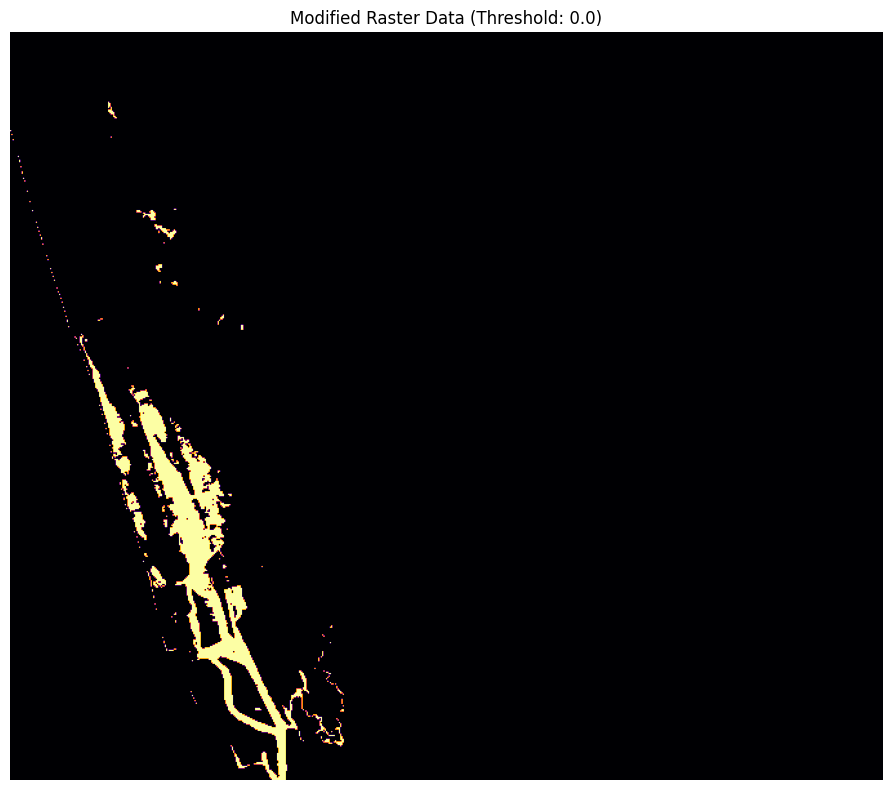

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.18651124794387	10.324729444499999	76.18817652694239	10.328892642
1	1	76.18651124794387	10.318068328499999	76.1923397244387	10.325562084
2	1	76.123230646	10.3097419335	76.12406328549926	10.310574573
3	1	76.12406328549926	10.307244015	76.12489592499851	10.308076654499999
4	1	76.18817652694239	10.305578736	76.18900916644165	10.3064113755
5	1	76.12489592499851	10.303913457	76.12572856449778	10.304746096499999
6	1	76.12822648299556	10.2930891435	76.12905912249482	10.293921783
7	1	76.12905912249482	10.2897585855	76.12989176199409	10.291423864499999
8	1	76.12989176199409	10.2864280275	76.13072440149335	10.287260667
9	1	76.13072440149335	10.282264829999999	76.1315570409926	10.283930109
10	1	76.1315570409926	10.278934271999999	76.13238968049187	10.2797669115
11	1	76.13238968049187	10.277268993	76.13322231999113	10.2781016325
12	1	76.1340549594904	10.270607877	76.13488759898965	10.2714405165
13	1	76.1357202

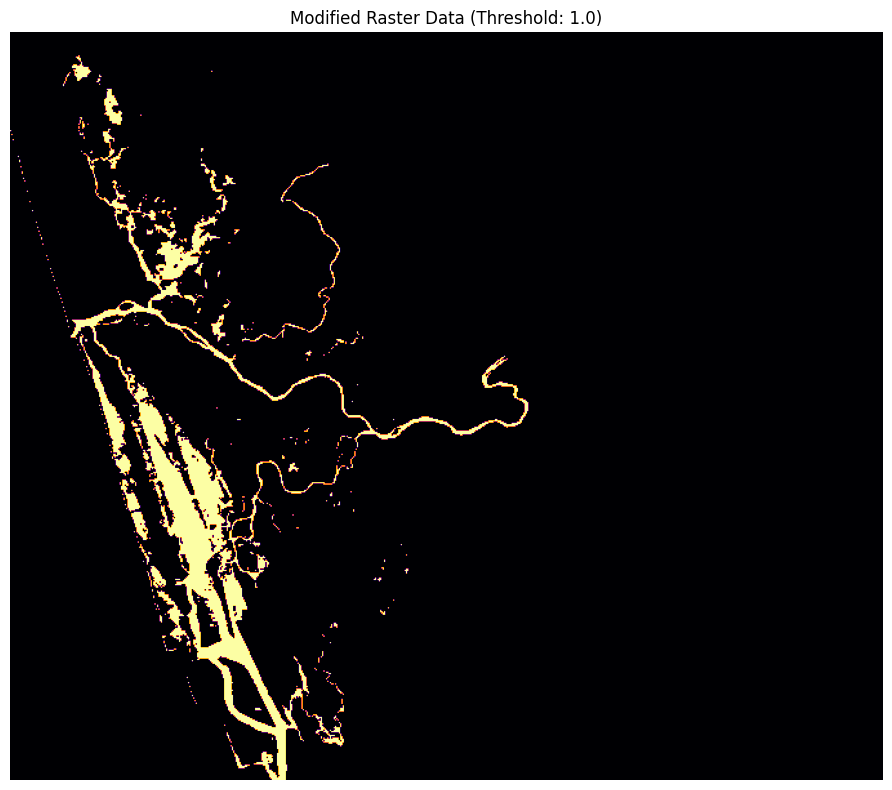

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.16569526046233	10.3547044665	76.16902581845937	10.358867664
1	1	76.25312240788479	10.3480433505	76.25395504738404	10.34887599
2	1	76.16153206296602	10.347210710999999	76.16236470246528	10.3480433505
3	1	76.1598667839675	10.3447127925	76.16153206296602	10.347210710999999
4	1	76.18068277144904	10.3447127925	76.18234805044756	10.346378071499998
5	1	76.16319734196455	10.342214874	76.17568693445347	10.3547044665
6	1	76.15903414446824	10.342214874	76.1598667839675	10.3447127925
7	1	76.15820150496897	10.340549594999999	76.15903414446824	10.342214874
8	1	76.17901749245051	10.3413822345	76.1815154109483	10.343880152999999
9	1	76.15736886546972	10.338884316	76.15820150496897	10.340549594999999
10	1	76.18068277144904	10.3397169555	76.1815154109483	10.340549594999999
11	1	76.2073272354254	10.3197336075	76.20815987492466	10.320566246999999
12	1	76.16819317896011	10.317235688999999	76.16985845795864	10.31890096

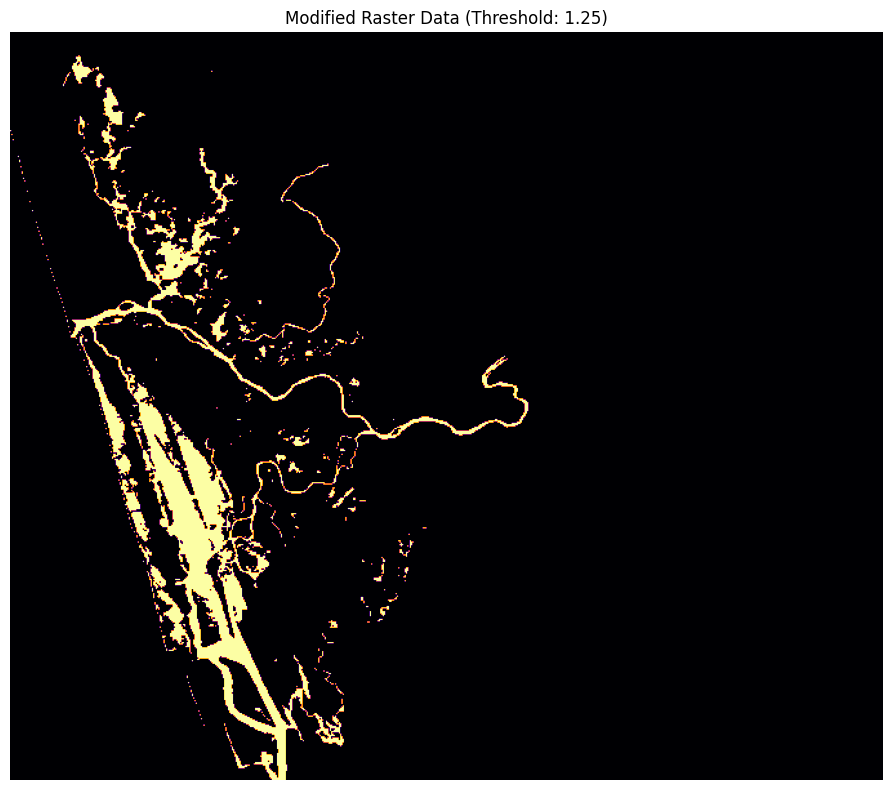

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.17651957395273	10.34887599	76.177352213452	10.350541268999999
1	1	76.17818485295125	10.34887599	76.18068277144904	10.3513739085
2	1	76.25312240788479	10.3480433505	76.25395504738404	10.34887599
3	1	76.16153206296602	10.347210710999999	76.16236470246528	10.3480433505
4	1	76.1598667839675	10.3447127925	76.16153206296602	10.347210710999999
5	1	76.16319734196455	10.340549594999999	76.17651957395273	10.358867664
6	1	76.15903414446824	10.342214874	76.1598667839675	10.3447127925
7	1	76.17818485295125	10.3380516765	76.18401332944609	10.347210710999999
8	1	76.15820150496897	10.340549594999999	76.15903414446824	10.342214874
9	1	76.15736886546972	10.338884316	76.15820150496897	10.340549594999999
10	1	76.20399667742835	10.3164030495	76.21065779342244	10.322231526
11	1	76.16486262096306	10.3164030495	76.16569526046233	10.317235688999999
12	1	76.17318901595569	10.313905130999999	76.17402165545495	10.31473777049

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.25312240788479	10.3480433505	76.25395504738404	10.34887599
1	1	76.16153206296602	10.347210710999999	76.16236470246528	10.3480433505
2	1	76.1598667839675	10.3447127925	76.16153206296602	10.347210710999999
3	1	76.16236470246528	10.3397169555	76.1815154109483	10.358867664
4	1	76.15903414446824	10.342214874	76.1598667839675	10.3447127925
5	1	76.17818485295125	10.3380516765	76.18401332944609	10.347210710999999
6	1	76.15820150496897	10.340549594999999	76.15903414446824	10.342214874
7	1	76.15736886546972	10.338884316	76.15820150496897	10.340549594999999
8	1	76.25728560538109	10.3363863975	76.26311408187593	10.340549594999999
9	1	76.15403830747267	10.333888478999999	76.15487094697193	10.3347211185
10	1	76.15653622597046	10.3263947235	76.15736886546972	10.327227362999999
11	1	76.17235637645642	10.318900968	76.17402165545495	10.320566246999999
12	1	76.16236470246528	10.3164030495	76.16569526046233	10.317235

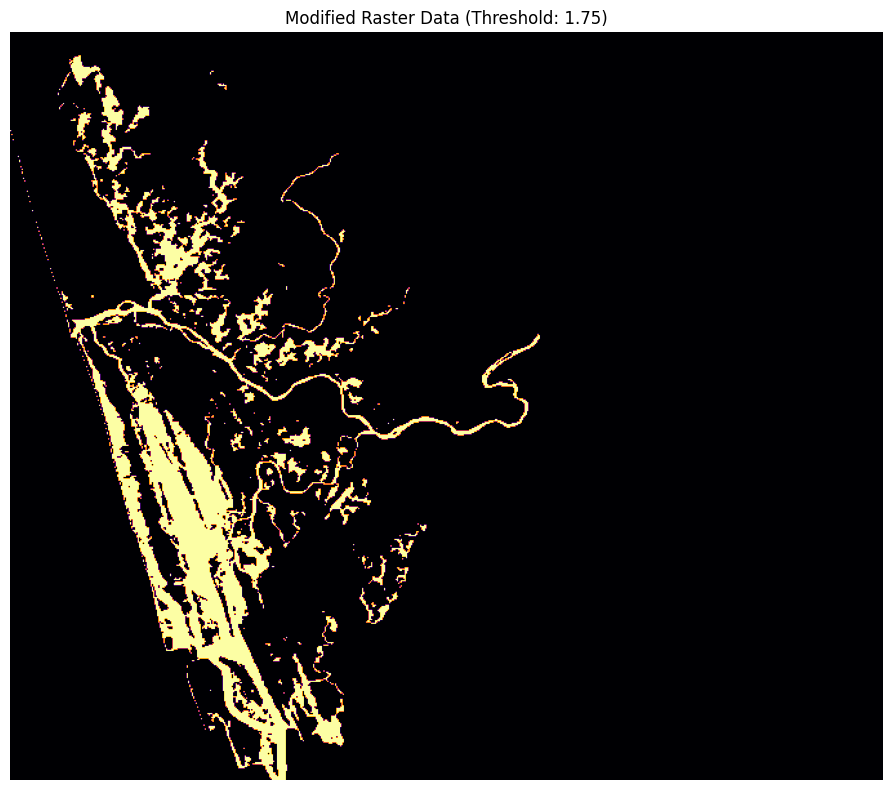

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.16153206296602	10.355537106	76.16236470246528	10.356369745499999
1	1	76.25312240788479	10.3480433505	76.2547876868833	10.34887599
2	1	76.16153206296602	10.347210710999999	76.16236470246528	10.3480433505
3	1	76.25228976838552	10.346378071499998	76.25312240788479	10.3480433505
4	1	76.1598667839675	10.3447127925	76.16153206296602	10.347210710999999
5	1	76.16153206296602	10.338884316	76.1815154109483	10.358867664
6	1	76.15653622597046	10.3380516765	76.1598667839675	10.3447127925
7	1	76.25728560538109	10.3363863975	76.26311408187593	10.340549594999999
8	1	76.15487094697193	10.3363863975	76.15570358647119	10.337219036999999
9	1	76.177352213452	10.335553758	76.18401332944609	10.3480433505
10	1	76.18068277144904	10.333888478999999	76.1815154109483	10.335553758
11	1	76.15403830747267	10.3330558395	76.15487094697193	10.3347211185
12	1	76.15736886546972	10.327227362999999	76.15820150496897	10.3280600025
13	1

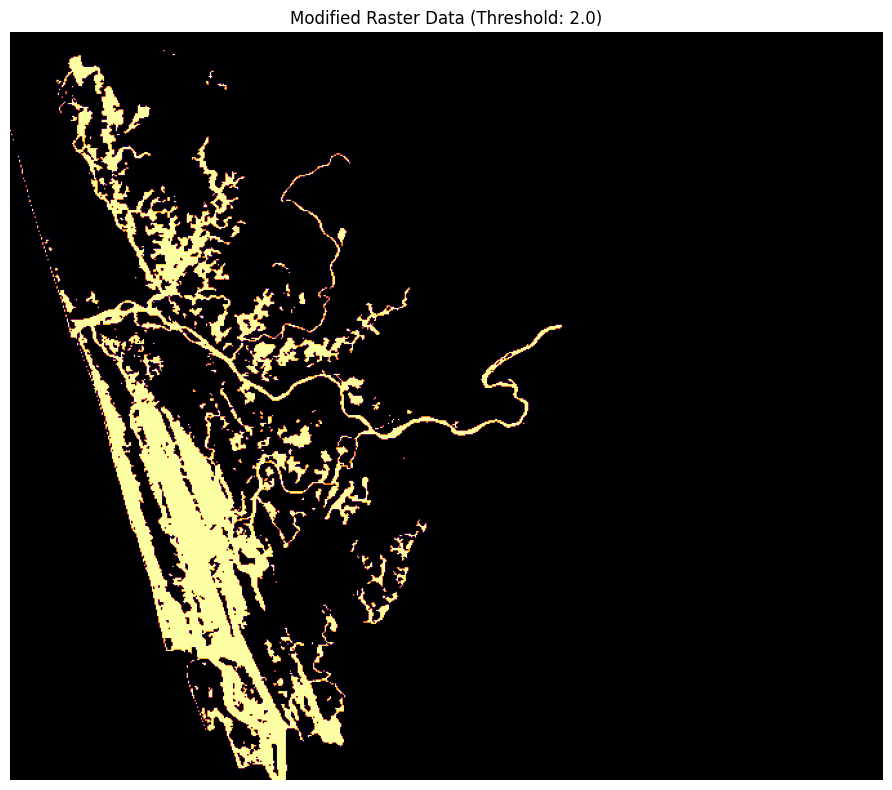

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.22231474641211	10.3613655825	76.22314738591137	10.362198222
1	1	76.22814322290694	10.358867664	76.22980850190547	10.359700303499999
2	1	76.25312240788479	10.3480433505	76.2547876868833	10.34887599
3	1	76.25145712888626	10.343880152999999	76.25395504738404	10.3480433505
4	1	76.15320566797341	10.3413822345	76.15487094697193	10.3430475135
5	1	76.24979184988774	10.3397169555	76.25145712888626	10.342214874
6	1	76.15403830747267	10.340549594999999	76.15653622597046	10.342214874
7	1	76.16319734196455	10.3380516765	76.16402998146381	10.338884316
8	1	76.25728560538109	10.3363863975	76.26311408187593	10.340549594999999
9	1	76.15487094697193	10.3363863975	76.15570358647119	10.337219036999999
10	1	76.15653622597046	10.333888478999999	76.18401332944609	10.358867664
11	1	76.15903414446824	10.333888478999999	76.1598667839675	10.335553758
12	1	76.15403830747267	10.3330558395	76.15487094697193	10.3347211185
13	1	7

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.22231474641211	10.3613655825	76.22398002541063	10.362198222
1	1	76.22814322290694	10.358867664	76.22980850190547	10.359700303499999
2	1	76.25145712888626	10.343880152999999	76.25645296588183	10.34887599
3	1	76.15570358647119	10.343880152999999	76.15653622597046	10.3447127925
4	1	76.25728560538109	10.343880152999999	76.26311408187593	10.345545432
5	1	76.24729393138995	10.3397169555	76.25145712888626	10.3430475135
6	1	76.2464612918907	10.3397169555	76.24729393138995	10.340549594999999
7	1	76.26727727937222	10.3363863975	76.26810991887149	10.3380516765
8	1	76.25728560538109	10.3347211185	76.26561200037371	10.3413822345
9	1	76.16236470246528	10.335553758	76.16486262096306	10.338884316
10	1	76.15736886546972	10.333888478999999	76.16069942346677	10.335553758
11	1	76.15403830747267	10.3313905605	76.15820150496897	10.337219036999999
12	1	76.15820150496897	10.330557920999999	76.15903414446824	10.3313905605

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.22148210691284	10.3613655825	76.22481266490989	10.362198222
1	1	76.22481266490989	10.359700303499999	76.22564530440916	10.3613655825
2	1	76.22814322290694	10.3580350245	76.23147378090398	10.360532942999999
3	1	76.15820150496897	10.353039187499999	76.15903414446824	10.353871826999999
4	1	76.15820150496897	10.350541268999999	76.15903414446824	10.3513739085
5	1	76.2439633733929	10.337219036999999	76.26394672137518	10.34887599
6	1	76.25645296588183	10.3347211185	76.26894255837075	10.342214874
7	1	76.15820150496897	10.330557920999999	76.15903414446824	10.3313905605
8	1	76.15820150496897	10.318068328499999	76.15903414446824	10.318900968
9	1	76.123230646	10.3097419335	76.12406328549926	10.311407212499999
10	1	76.12406328549926	10.307244015	76.12489592499851	10.308909294
11	1	76.19150708493943	10.307244015	76.21482099091875	10.3280600025
12	1	76.12489592499851	10.303913457	76.12572856449778	10.30474609649

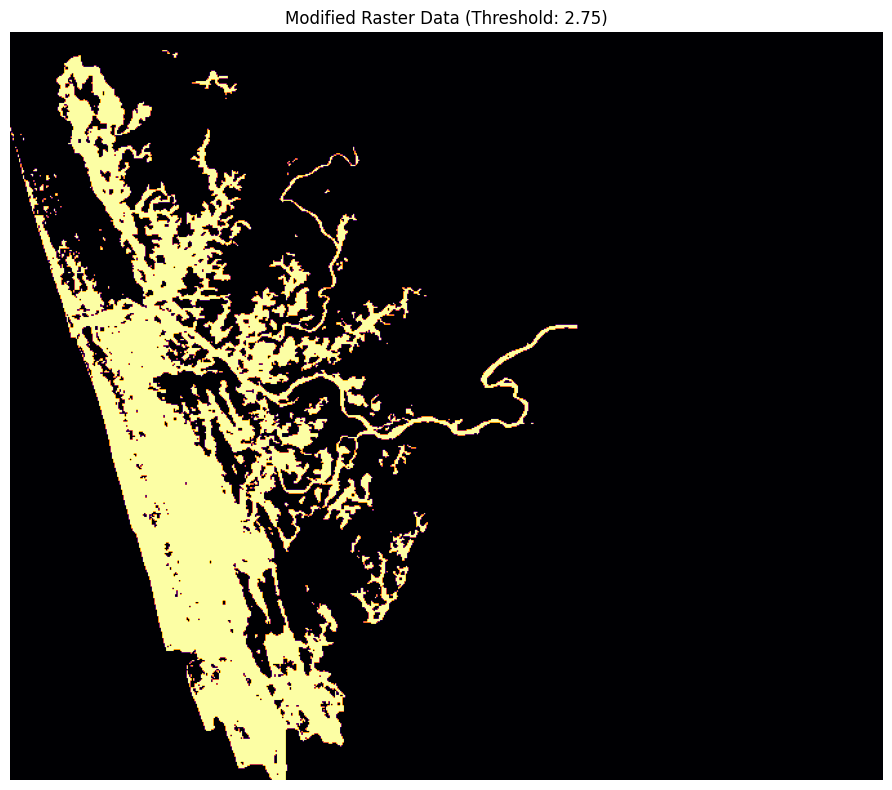

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.22148210691284	10.3613655825	76.22481266490989	10.362198222
1	1	76.22481266490989	10.359700303499999	76.22647794390842	10.3613655825
2	1	76.22814322290694	10.357202384999999	76.23147378090398	10.360532942999999
3	1	76.16153206296602	10.3413822345	76.16319734196455	10.3430475135
4	1	76.24063281539586	10.3330558395	76.26977519787002	10.34887599
5	1	76.26228144237666	10.330557920999999	76.26311408187593	10.3313905605
6	1	76.177352213452	10.325562084	76.17818485295125	10.3263947235
7	1	76.123230646	10.3097419335	76.12406328549926	10.312239852
8	1	76.12406328549926	10.3064113755	76.12572856449778	10.308909294
9	1	76.12989176199409	10.307244015	76.13072440149335	10.308076654499999
10	1	76.12489592499851	10.303913457	76.12572856449778	10.305578736
11	1	76.1315570409926	10.303913457	76.13238968049187	10.305578736
12	1	76.12656120399704	10.29891762	76.12739384349631	10.2997502595
13	1	76.34471275280355	10.

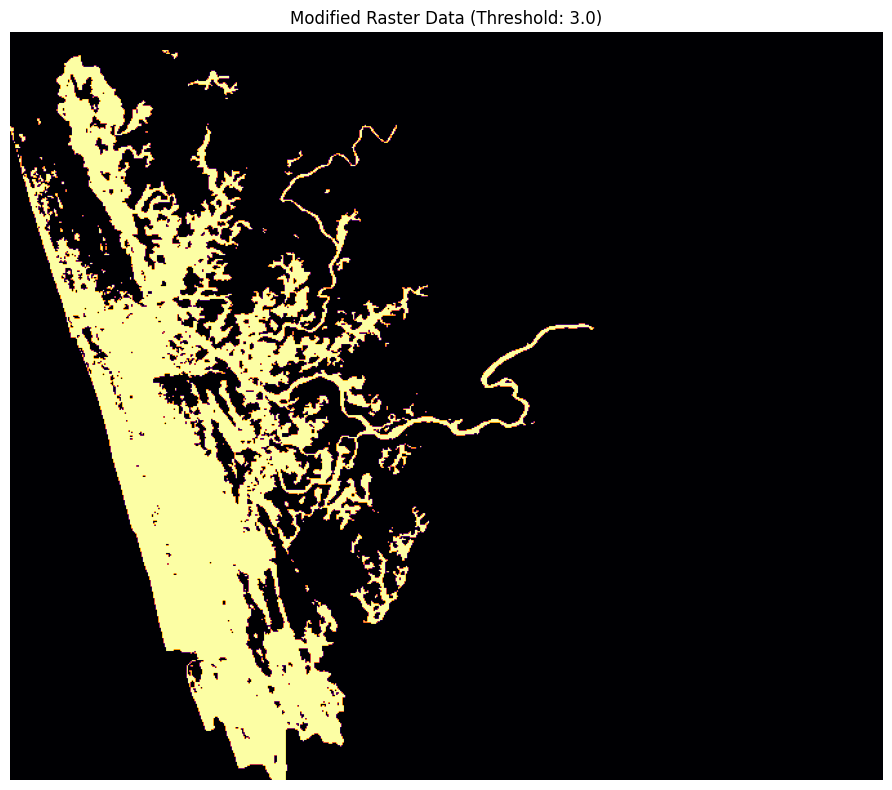

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.22148210691284	10.359700303499999	76.22647794390842	10.362198222
1	1	76.22731058340767	10.356369745499999	76.23147378090398	10.360532942999999
2	1	76.25312240788479	10.338884316	76.25395504738404	10.3397169555
3	1	76.23813489689807	10.3330558395	76.27060783736927	10.34887599
4	1	76.17651957395273	10.3313905605	76.177352213452	10.3322232
5	1	76.26228144237666	10.330557920999999	76.26394672137518	10.3313905605
6	1	76.17651957395273	10.323896804999999	76.17901749245051	10.327227362999999
7	1	76.14071607548449	10.313905130999999	76.14321399398227	10.318068328499999
8	1	76.177352213452	10.313905130999999	76.17901749245051	10.314737770499999
9	1	76.250624489387	10.313905130999999	76.25145712888626	10.314737770499999
10	1	76.123230646	10.303913457	76.12572856449778	10.3130724915
11	1	76.21065779342244	10.308909294	76.21232307242097	10.3097419335
12	1	76.12905912249482	10.3030808175	76.13322231999113	10.3

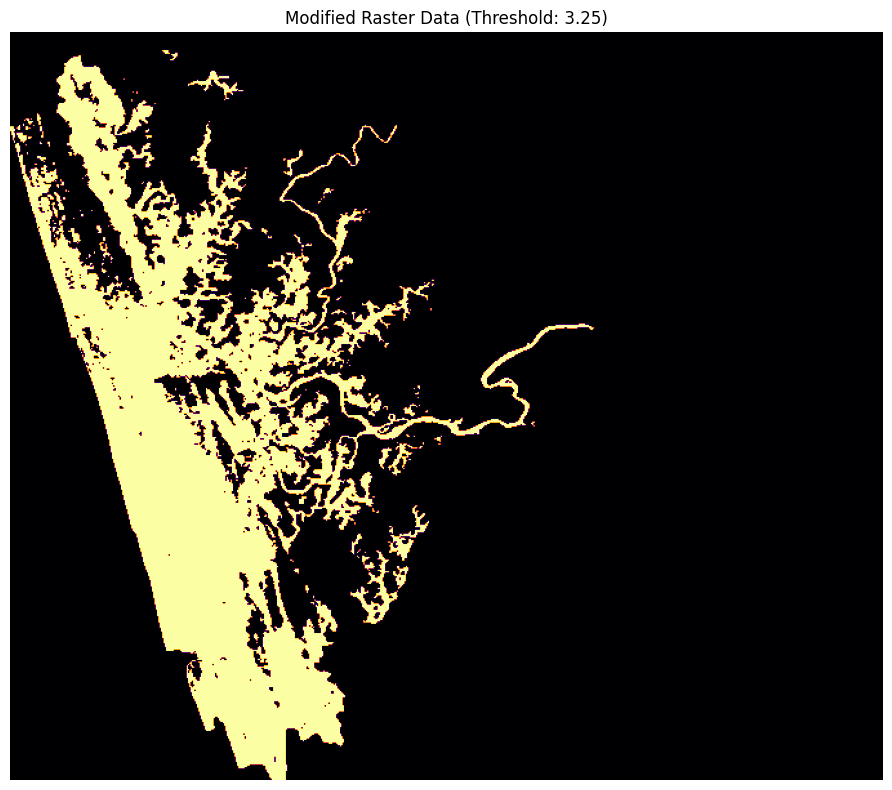

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.22148210691284	10.359700303499999	76.22647794390842	10.362198222
1	1	76.22647794390842	10.355537106	76.23147378090398	10.360532942999999
2	1	76.19650292193501	10.3430475135	76.19733556143427	10.343880152999999
3	1	76.25312240788479	10.338884316	76.25395504738404	10.3397169555
4	1	76.23813489689807	10.330557920999999	76.27060783736927	10.34887599
5	1	76.27060783736927	10.335553758	76.27393839536632	10.3363863975
6	1	76.20233139842983	10.3347211185	76.2031640379291	10.335553758
7	1	76.20482931692761	10.333888478999999	76.20566195642688	10.335553758
8	1	76.2614488028774	10.3297252815	76.26228144237666	10.330557920999999
9	1	76.20149875893057	10.328892642	76.20233139842983	10.330557920999999
10	1	76.21648626991728	10.327227362999999	76.21731890941653	10.3280600025
11	1	76.13655287798818	10.317235688999999	76.13738551748744	10.318068328499999
12	1	76.13238968049187	10.3164030495	76.13322231999113	10.31

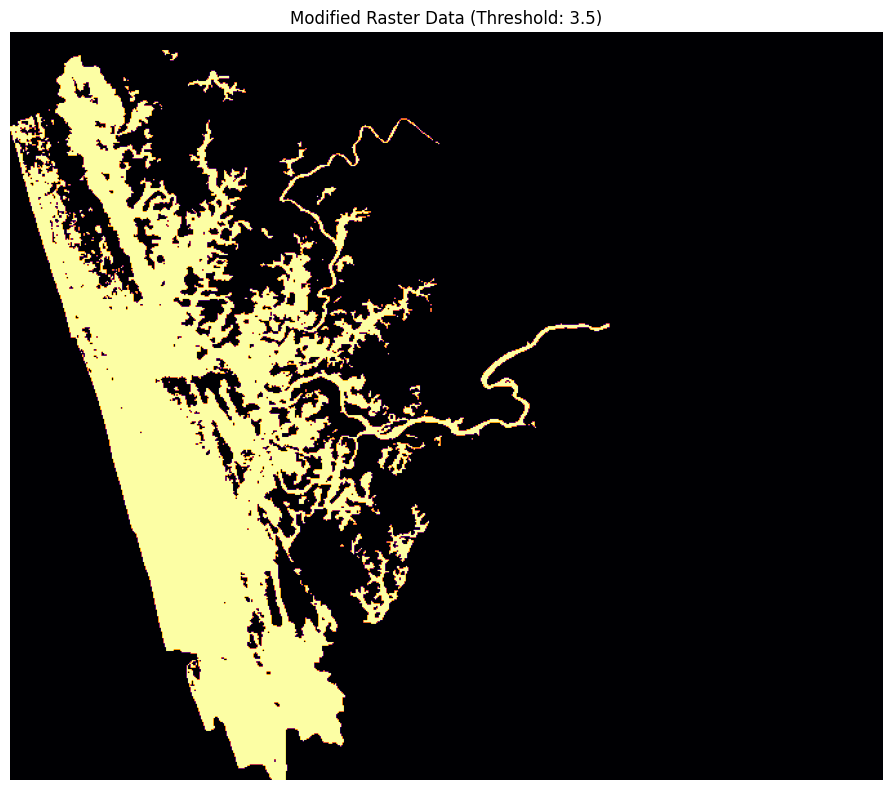

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.22148210691284	10.358867664	76.22647794390842	10.362198222
1	1	76.22647794390842	10.355537106	76.23147378090398	10.360532942999999
2	1	76.19650292193501	10.342214874	76.19816820093352	10.3447127925
3	1	76.19900084043279	10.342214874	76.19983347993205	10.3430475135
4	1	76.25312240788479	10.3380516765	76.25395504738404	10.3397169555
5	1	76.19733556143427	10.3363863975	76.19983347993205	10.338884316
6	1	76.23813489689807	10.3297252815	76.27560367436485	10.34887599
7	1	76.19983347993205	10.328892642	76.20649459592615	10.3363863975
8	1	76.26061616337813	10.328892642	76.2614488028774	10.3297252815
9	1	76.21565363041802	10.327227362999999	76.21898418841506	10.328892642
10	1	76.21981682791433	10.3263947235	76.22064946741358	10.327227362999999
11	1	76.22064946741358	10.325562084	76.22148210691284	10.3263947235
12	1	76.22064946741358	10.323896804999999	76.22148210691284	10.324729444499999
13	1	76.1482098309

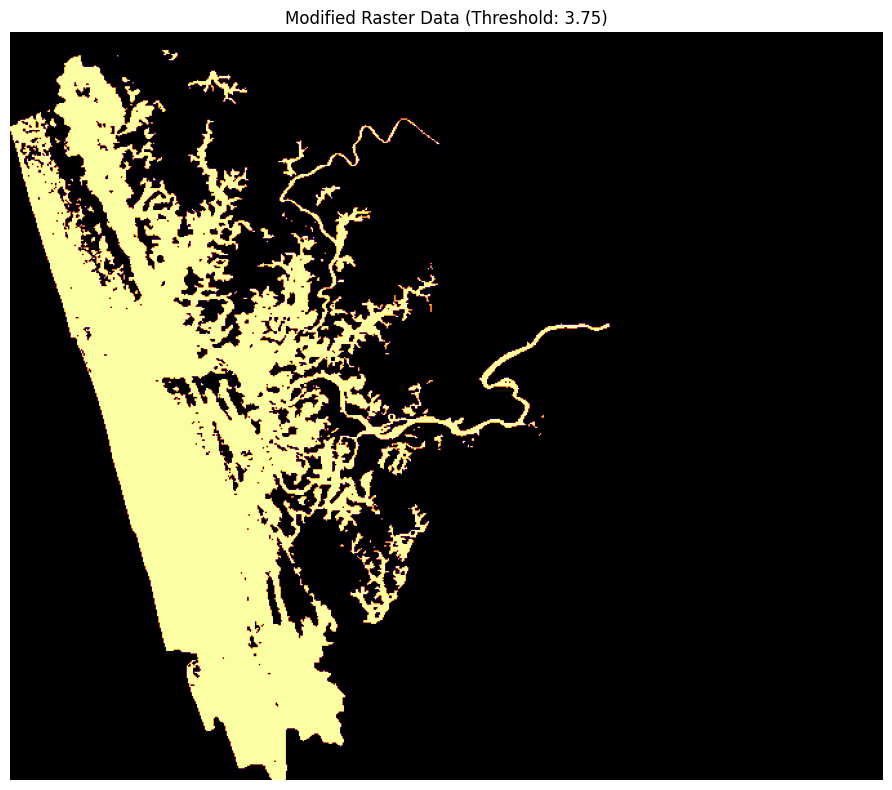

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.22148210691284	10.358867664	76.22647794390842	10.362198222
1	1	76.1923397244387	10.3580350245	76.19317236393796	10.358867664
2	1	76.22564530440916	10.355537106	76.23147378090398	10.360532942999999
3	1	76.19567028243574	10.3413822345	76.20066611943132	10.3447127925
4	1	76.20233139842983	10.340549594999999	76.2031640379291	10.3413822345
5	1	76.23896753639734	10.337219036999999	76.2398001758966	10.3380516765
6	1	76.27477103486558	10.337219036999999	76.27560367436485	10.3380516765
7	1	76.25312240788479	10.335553758	76.2547876868833	10.3397169555
8	1	76.19733556143427	10.3280600025	76.2073272354254	10.338884316
9	1	76.23813489689807	10.327227362999999	76.27643631386411	10.34887599
10	1	76.20066611943132	10.3263947235	76.20233139842983	10.327227362999999
11	1	76.19816820093352	10.323896804999999	76.19900084043279	10.324729444499999
12	1	76.21565363041802	10.322231526	76.22398002541063	10.3297252815
13	1

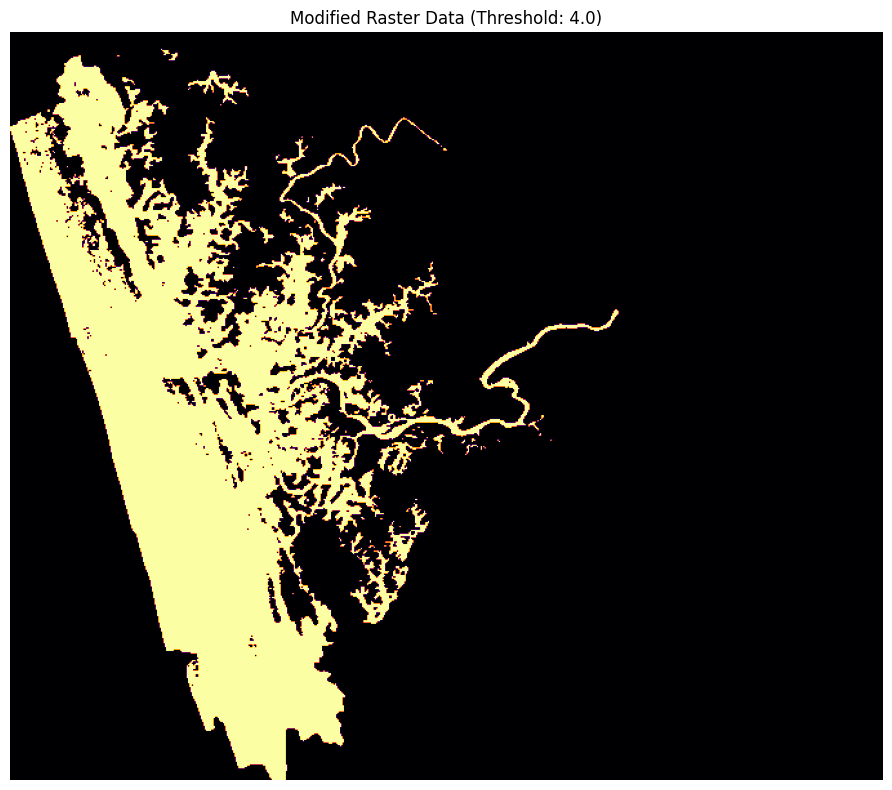

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.22064946741358	10.362198222	76.22148210691284	10.363030861499999
1	1	76.22148210691284	10.358867664	76.22647794390842	10.362198222
2	1	76.1923397244387	10.3580350245	76.19400500343723	10.358867664
3	1	76.22564530440916	10.355537106	76.23147378090398	10.360532942999999
4	1	76.19567028243574	10.340549594999999	76.2031640379291	10.3447127925
5	1	76.2031640379291	10.3397169555	76.20399667742835	10.340549594999999
6	1	76.23896753639734	10.337219036999999	76.2398001758966	10.3380516765
7	1	76.23813489689807	10.3363863975	76.23896753639734	10.337219036999999
8	1	76.23813489689807	10.327227362999999	76.27726895336336	10.34887599
9	1	76.25895088437962	10.3263947235	76.25978352387888	10.327227362999999
10	1	76.21565363041802	10.320566246999999	76.22564530440916	10.3297252815
11	1	76.14737719147858	10.322231526	76.1490424704771	10.323896804999999
12	1	76.37968361177252	10.3130724915	76.38551208826735	10.3172

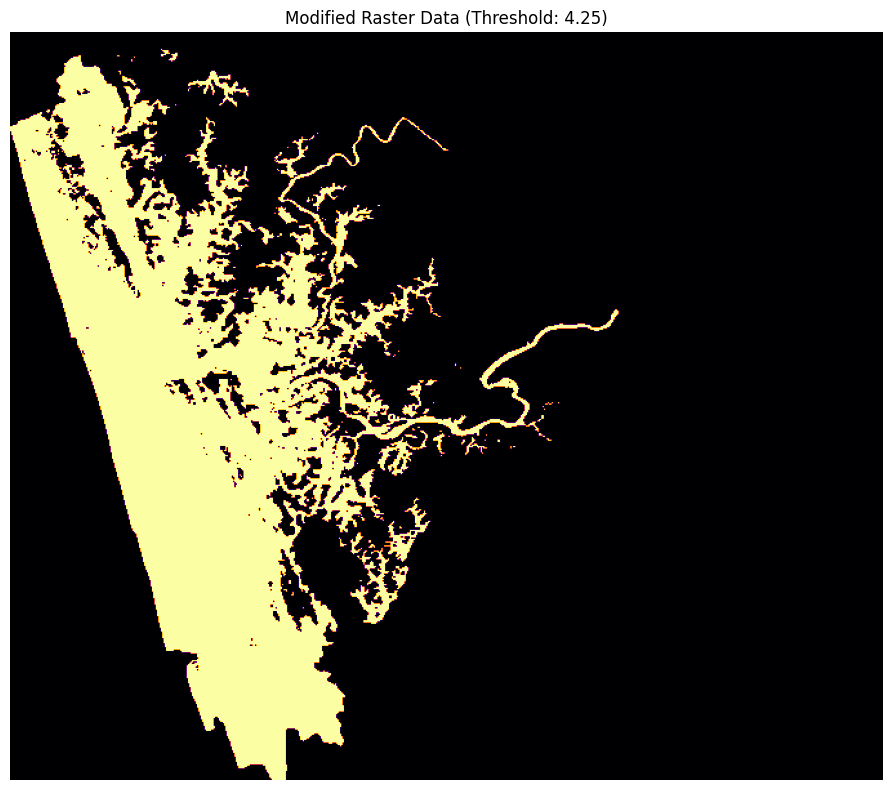

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.22064946741358	10.362198222	76.22148210691284	10.363030861499999
1	1	76.22064946741358	10.3580350245	76.22647794390842	10.362198222
2	1	76.1923397244387	10.3580350245	76.19400500343723	10.358867664
3	1	76.2031640379291	10.357202384999999	76.20399667742835	10.3580350245
4	1	76.20149875893057	10.3547044665	76.20233139842983	10.356369745499999
5	1	76.22564530440916	10.3547044665	76.23147378090398	10.360532942999999
6	1	76.19317236393796	10.346378071499998	76.19483764293648	10.34887599
7	1	76.19567028243574	10.338884316	76.20482931692761	10.345545432
8	1	76.24479601289217	10.3380516765	76.24562865239143	10.338884316
9	1	76.23896753639734	10.337219036999999	76.2398001758966	10.3380516765
10	1	76.23813489689807	10.335553758	76.23896753639734	10.337219036999999
11	1	76.23813489689807	10.325562084	76.27726895336336	10.34887599
12	1	76.22980850190547	10.3263947235	76.23064114140472	10.327227362999999
13	1	

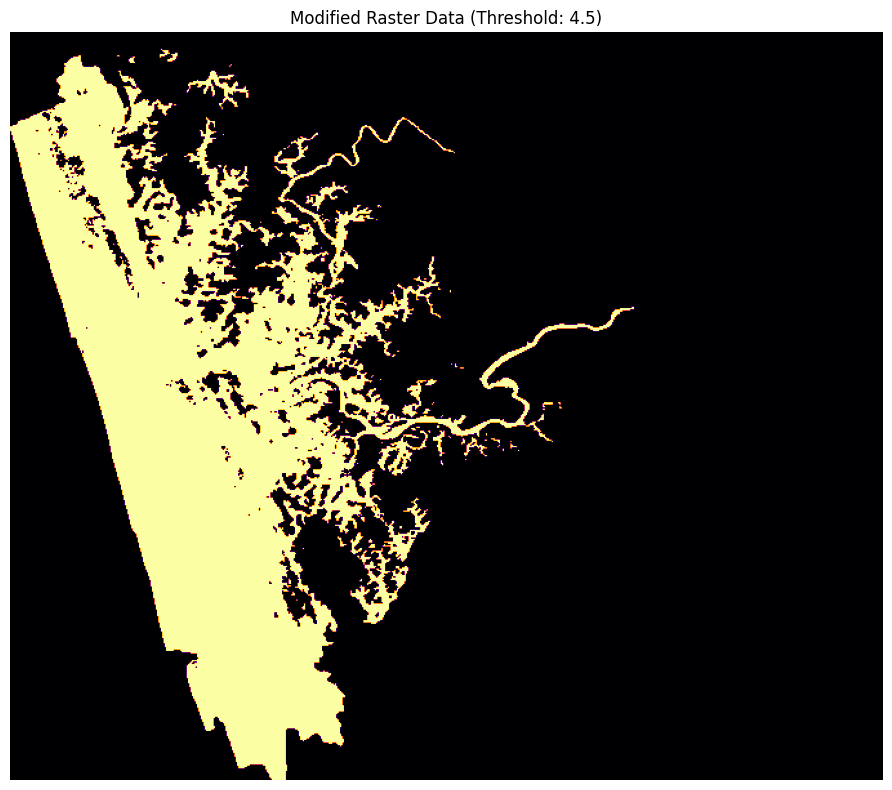

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.22064946741358	10.362198222	76.22148210691284	10.363030861499999
1	1	76.21981682791433	10.357202384999999	76.22647794390842	10.362198222
2	1	76.1923397244387	10.3580350245	76.19400500343723	10.358867664
3	1	76.19983347993205	10.353871826999999	76.20399667742835	10.3580350245
4	1	76.22481266490989	10.3547044665	76.23147378090398	10.360532942999999
5	1	76.26561200037371	10.352206548	76.26644463987297	10.353039187499999
6	1	76.26477936087444	10.3513739085	76.26561200037371	10.352206548
7	1	76.19317236393796	10.3380516765	76.20482931692761	10.34887599
8	1	76.23730225739881	10.3347211185	76.23896753639734	10.337219036999999
9	1	76.23813489689807	10.325562084	76.27726895336336	10.34887599
10	1	76.25811824488035	10.325562084	76.26061616337813	10.3280600025
11	1	76.2289758624062	10.3263947235	76.23064114140472	10.327227362999999
12	1	76.25978352387888	10.323896804999999	76.26061616337813	10.325562084
13	1

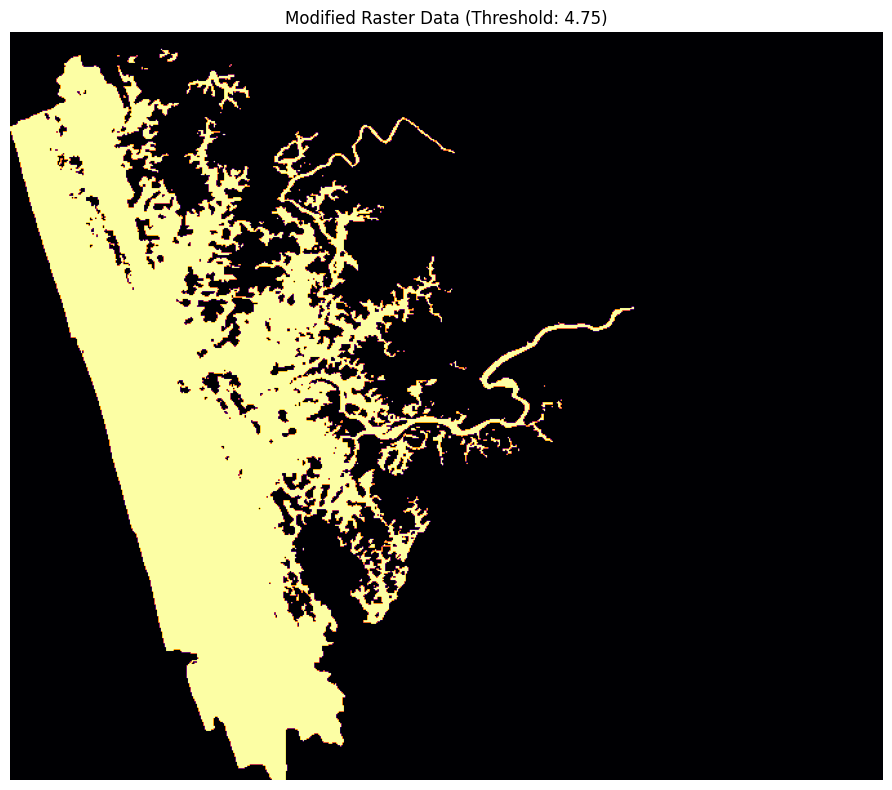

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.22064946741358	10.362198222	76.22148210691284	10.363030861499999
1	1	76.21981682791433	10.357202384999999	76.22647794390842	10.362198222
2	1	76.1923397244387	10.3580350245	76.19400500343723	10.358867664
3	1	76.20482931692761	10.3580350245	76.20566195642688	10.358867664
4	1	76.22481266490989	10.3547044665	76.23147378090398	10.360532942999999
5	1	76.19900084043279	10.353871826999999	76.20482931692761	10.3580350245
6	1	76.26561200037371	10.352206548	76.26644463987297	10.353039187499999
7	1	76.26477936087444	10.3513739085	76.26561200037371	10.352206548
8	1	76.20815987492466	10.349708629499998	76.20899251442393	10.3513739085
9	1	76.20982515392319	10.349708629499998	76.21232307242097	10.350541268999999
10	1	76.19650292193501	10.3313905605	76.19816820093352	10.3330558395
11	1	76.23730225739881	10.323896804999999	76.27810159286263	10.34887599
12	1	76.27144047686853	10.323896804999999	76.2722731163678	10.3

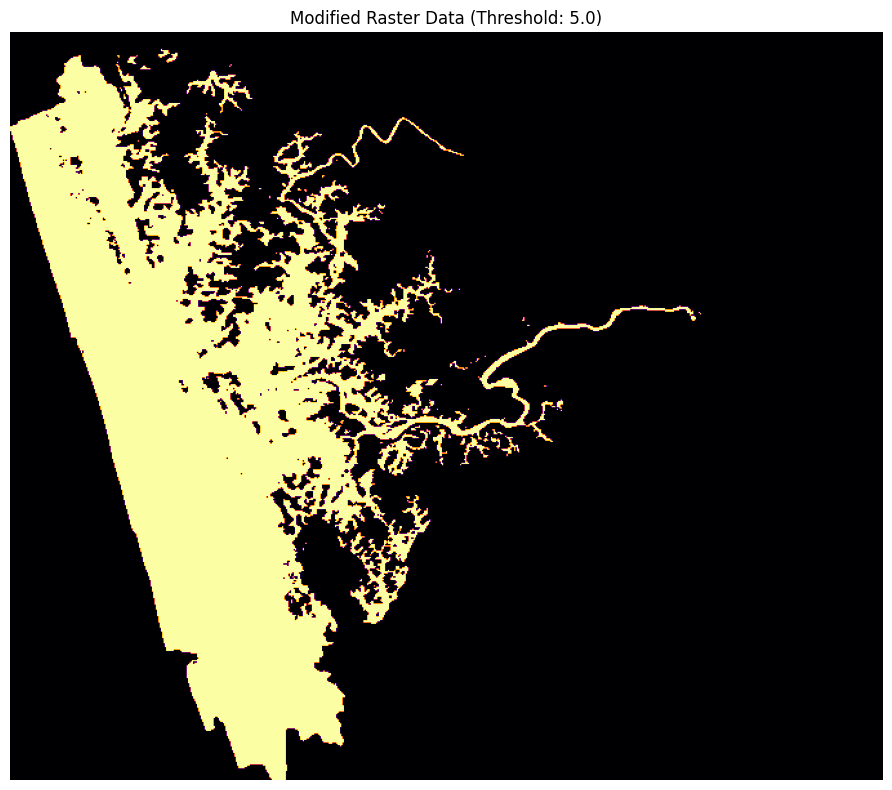

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.21898418841506	10.357202384999999	76.22647794390842	10.363030861499999
1	1	76.1923397244387	10.357202384999999	76.19400500343723	10.358867664
2	1	76.20482931692761	10.3580350245	76.20566195642688	10.358867664
3	1	76.19900084043279	10.353039187499999	76.20482931692761	10.3580350245
4	1	76.22398002541063	10.353871826999999	76.23147378090398	10.360532942999999
5	1	76.1923397244387	10.353871826999999	76.19317236393796	10.3547044665
6	1	76.26561200037371	10.352206548	76.26644463987297	10.353039187499999
7	1	76.26477936087444	10.3513739085	76.26561200037371	10.352206548
8	1	76.2073272354254	10.349708629499998	76.21398835141949	10.352206548
9	1	76.19400500343723	10.337219036999999	76.19483764293648	10.3380516765
10	1	76.19483764293648	10.335553758	76.19567028243574	10.337219036999999
11	1	76.19650292193501	10.330557920999999	76.19816820093352	10.333888478999999
12	1	76.27144047686853	10.323896804999999	7

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.28476270885672	10.362198222	76.28559534835598	10.363030861499999
1	1	76.21898418841506	10.357202384999999	76.22647794390842	10.363030861499999
2	1	76.1923397244387	10.357202384999999	76.19400500343723	10.358867664
3	1	76.20482931692761	10.3580350245	76.20566195642688	10.358867664
4	1	76.19900084043279	10.352206548	76.20482931692761	10.3580350245
5	1	76.22398002541063	10.353871826999999	76.23147378090398	10.360532942999999
6	1	76.22314738591137	10.353871826999999	76.22398002541063	10.3547044665
7	1	76.26561200037371	10.352206548	76.26644463987297	10.353039187499999
8	1	76.26477936087444	10.3513739085	76.26561200037371	10.352206548
9	1	76.2073272354254	10.34887599	76.21398835141949	10.352206548
10	1	76.19400500343723	10.3347211185	76.19650292193501	10.338884316
11	1	76.19567028243574	10.330557920999999	76.19816820093352	10.333888478999999
12	1	76.28143215085967	10.3313905605	76.28226479035894	10.332

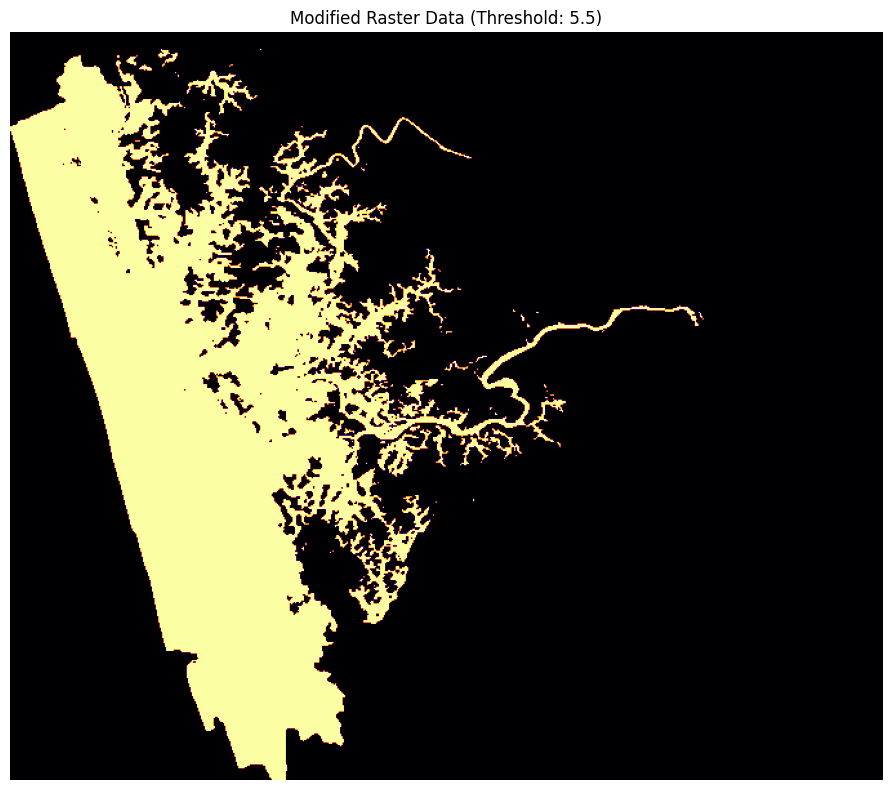

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.28476270885672	10.362198222	76.28559534835598	10.363030861499999
1	1	76.21898418841506	10.357202384999999	76.22647794390842	10.363030861499999
2	1	76.1923397244387	10.357202384999999	76.19400500343723	10.358867664
3	1	76.20482931692761	10.3580350245	76.20566195642688	10.358867664
4	1	76.19816820093352	10.352206548	76.20482931692761	10.3580350245
5	1	76.22314738591137	10.353871826999999	76.23147378090398	10.360532942999999
6	1	76.22148210691284	10.3513739085	76.22314738591137	10.353871826999999
7	1	76.26561200037371	10.352206548	76.26727727937222	10.353039187499999
8	1	76.26477936087444	10.3513739085	76.26561200037371	10.352206548
9	1	76.20649459592615	10.34887599	76.21482099091875	10.353039187499999
10	1	76.22980850190547	10.347210710999999	76.23064114140472	10.3480433505
11	1	76.23147378090398	10.3447127925	76.23230642040325	10.346378071499998
12	1	76.2805995113604	10.3313905605	76.2830974298582	

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.22148210691284	10.36552878	76.22231474641211	10.366361419499999
1	1	76.28476270885672	10.3613655825	76.28559534835598	10.363030861499999
2	1	76.21898418841506	10.357202384999999	76.22647794390842	10.363030861499999
3	1	76.1923397244387	10.357202384999999	76.19400500343723	10.358867664
4	1	76.20482931692761	10.3580350245	76.20566195642688	10.358867664
5	1	76.19816820093352	10.352206548	76.20482931692761	10.3580350245
6	1	76.22148210691284	10.3513739085	76.23147378090398	10.360532942999999
7	1	76.20482931692761	10.3513739085	76.20566195642688	10.352206548
8	1	76.26477936087444	10.350541268999999	76.26727727937222	10.353039187499999
9	1	76.20566195642688	10.350541268999999	76.20649459592615	10.3513739085
10	1	76.20649459592615	10.34887599	76.21482099091875	10.353039187499999
11	1	76.2289758624062	10.346378071499998	76.23147378090398	10.3480433505
12	1	76.23147378090398	10.3447127925	76.23230642040325

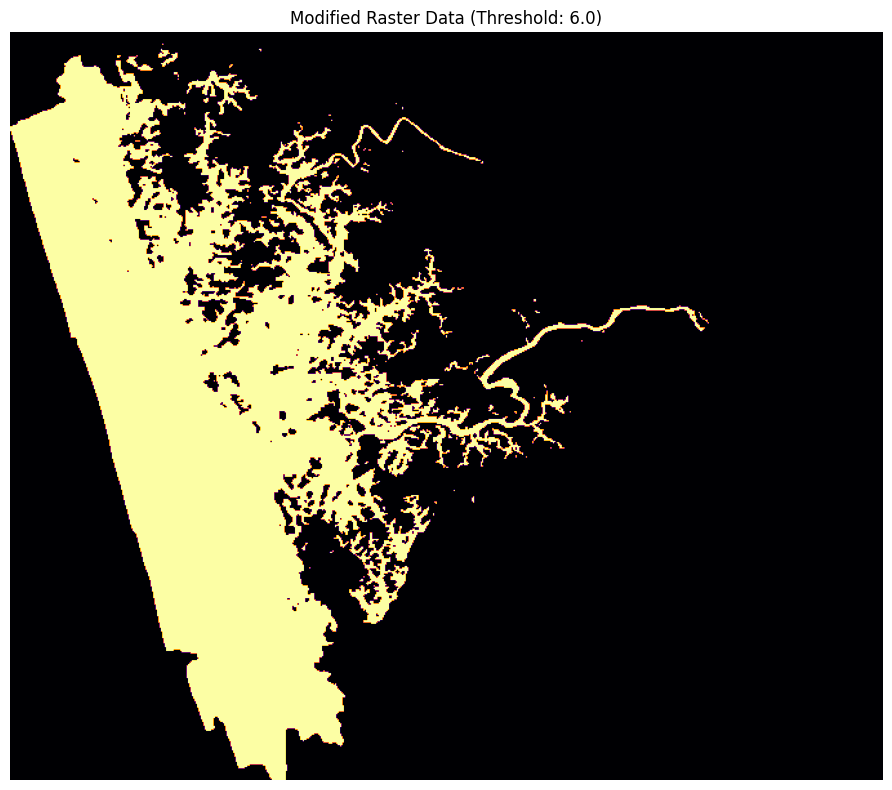

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.22148210691284	10.36552878	76.22231474641211	10.366361419499999
1	1	76.28393006935745	10.3613655825	76.28559534835598	10.363030861499999
2	1	76.21898418841506	10.357202384999999	76.22647794390842	10.363030861499999
3	1	76.1923397244387	10.357202384999999	76.19483764293648	10.358867664
4	1	76.20482931692761	10.3580350245	76.20566195642688	10.358867664
5	1	76.19816820093352	10.3513739085	76.20566195642688	10.3580350245
6	1	76.22064946741358	10.3513739085	76.23147378090398	10.360532942999999
7	1	76.26477936087444	10.350541268999999	76.26727727937222	10.353039187499999
8	1	76.20566195642688	10.34887599	76.21565363041802	10.353039187499999
9	1	76.2289758624062	10.346378071499998	76.23147378090398	10.3480433505
10	1	76.23147378090398	10.3447127925	76.23230642040325	10.346378071499998
11	1	76.23147378090398	10.3430475135	76.23230642040325	10.343880152999999
12	1	76.24812657088921	10.3280600025	76.2514571

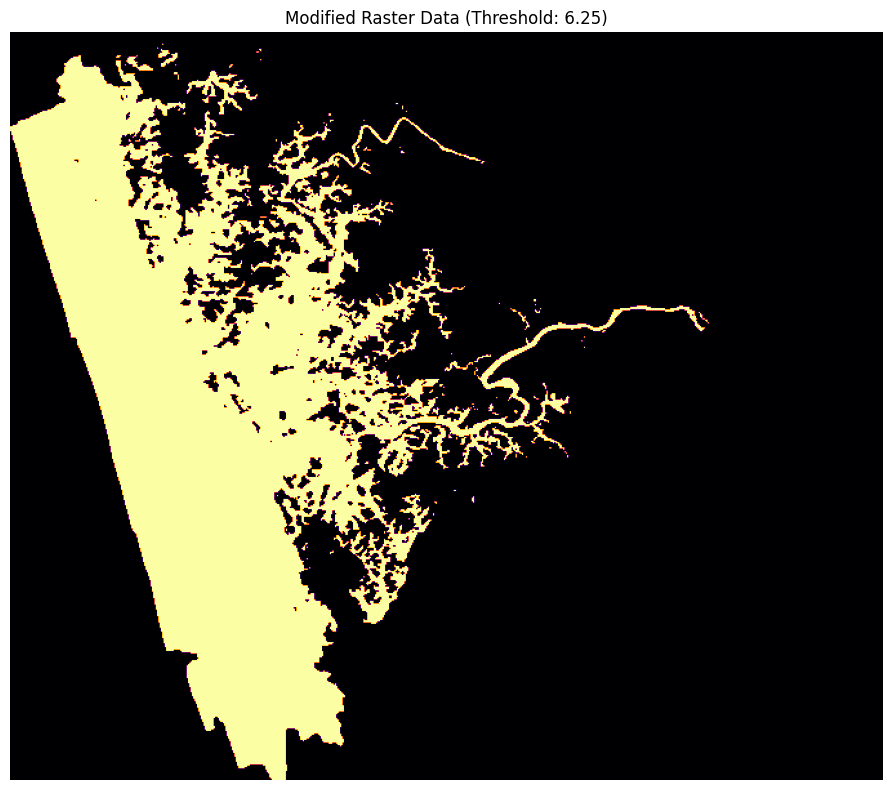

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.22148210691284	10.36552878	76.22231474641211	10.366361419499999
1	1	76.2181515489158	10.363030861499999	76.21898418841506	10.363863500999999
2	1	76.28393006935745	10.3613655825	76.28559534835598	10.363030861499999
3	1	76.28226479035894	10.360532942999999	76.28393006935745	10.3613655825
4	1	76.21898418841506	10.357202384999999	76.22647794390842	10.363030861499999
5	1	76.20482931692761	10.3580350245	76.20566195642688	10.358867664
6	1	76.19150708493943	10.357202384999999	76.19483764293648	10.358867664
7	1	76.28476270885672	10.355537106	76.28559534835598	10.356369745499999
8	1	76.22064946741358	10.3513739085	76.23147378090398	10.360532942999999
9	1	76.19733556143427	10.352206548	76.19816820093352	10.353039187499999
10	1	76.22980850190547	10.352206548	76.23064114140472	10.353039187499999
11	1	76.26477936087444	10.350541268999999	76.26727727937222	10.353039187499999
12	1	76.19816820093352	10.34887599	76

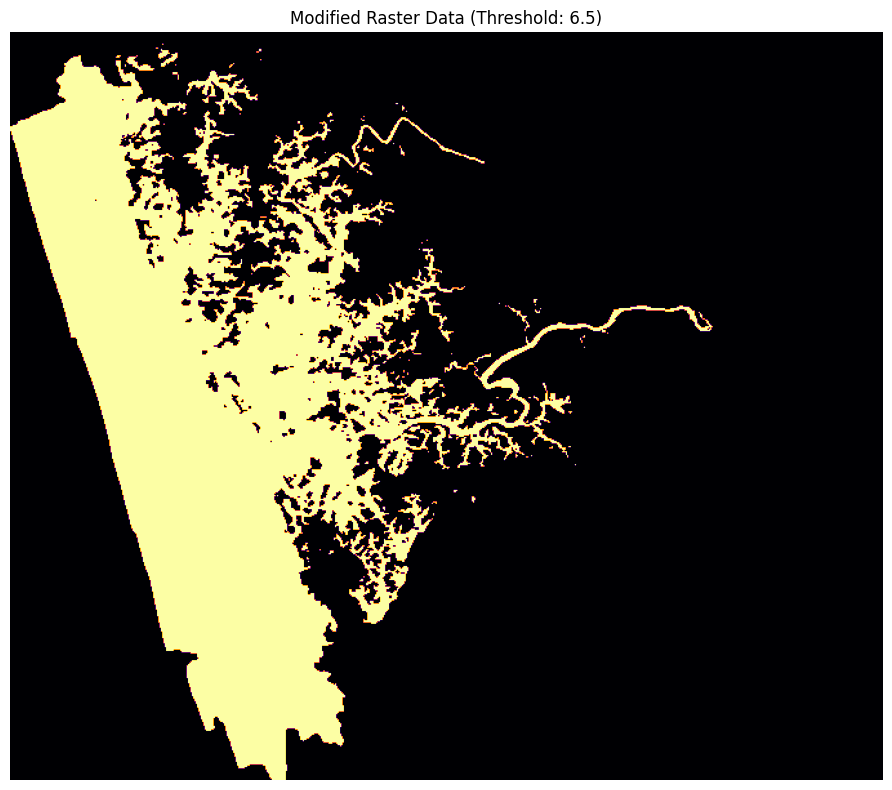

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.22148210691284	10.36552878	76.22231474641211	10.366361419499999
1	1	76.21731890941653	10.363030861499999	76.21898418841506	10.363863500999999
2	1	76.28393006935745	10.3613655825	76.28559534835598	10.363030861499999
3	1	76.28226479035894	10.360532942999999	76.28393006935745	10.3613655825
4	1	76.21898418841506	10.356369745499999	76.22647794390842	10.363030861499999
5	1	76.20482931692761	10.3580350245	76.20566195642688	10.358867664
6	1	76.19150708493943	10.357202384999999	76.19483764293648	10.358867664
7	1	76.28476270885672	10.355537106	76.28559534835598	10.356369745499999
8	1	76.22064946741358	10.3513739085	76.23147378090398	10.360532942999999
9	1	76.26727727937222	10.353039187499999	76.26810991887149	10.353871826999999
10	1	76.19733556143427	10.3513739085	76.19816820093352	10.353039187499999
11	1	76.22980850190547	10.352206548	76.23064114140472	10.353039187499999
12	1	76.26477936087444	10.350541268

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.22148210691284	10.36552878	76.22231474641211	10.366361419499999
1	1	76.21731890941653	10.363030861499999	76.22064946741358	10.3646961405
2	1	76.28393006935745	10.360532942999999	76.28559534835598	10.363030861499999
3	1	76.28226479035894	10.360532942999999	76.28393006935745	10.3613655825
4	1	76.21898418841506	10.356369745499999	76.22647794390842	10.363030861499999
5	1	76.20482931692761	10.3580350245	76.20566195642688	10.358867664
6	1	76.19150708493943	10.357202384999999	76.19483764293648	10.358867664
7	1	76.28393006935745	10.357202384999999	76.28476270885672	10.3580350245
8	1	76.28393006935745	10.355537106	76.28559534835598	10.356369745499999
9	1	76.22064946741358	10.3513739085	76.23147378090398	10.360532942999999
10	1	76.19733556143427	10.3513739085	76.19816820093352	10.353039187499999
11	1	76.22980850190547	10.352206548	76.23064114140472	10.353039187499999
12	1	76.26477936087444	10.35054126899999

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.22148210691284	10.36552878	76.22231474641211	10.366361419499999
1	1	76.21731890941653	10.362198222	76.22064946741358	10.3646961405
2	1	76.21898418841506	10.356369745499999	76.22647794390842	10.363030861499999
3	1	76.20482931692761	10.3580350245	76.20566195642688	10.358867664
4	1	76.19150708493943	10.357202384999999	76.19483764293648	10.358867664
5	1	76.28226479035894	10.3547044665	76.28559534835598	10.363030861499999
6	1	76.26644463987297	10.353871826999999	76.26727727937222	10.3547044665
7	1	76.22064946741358	10.3513739085	76.23147378090398	10.360532942999999
8	1	76.22980850190547	10.352206548	76.23064114140472	10.353871826999999
9	1	76.19733556143427	10.3513739085	76.19816820093352	10.353039187499999
10	1	76.26477936087444	10.350541268999999	76.26810991887149	10.353871826999999
11	1	76.19816820093352	10.3480433505	76.21648626991728	10.3580350245
12	1	76.22814322290694	10.346378071499998	76.23147

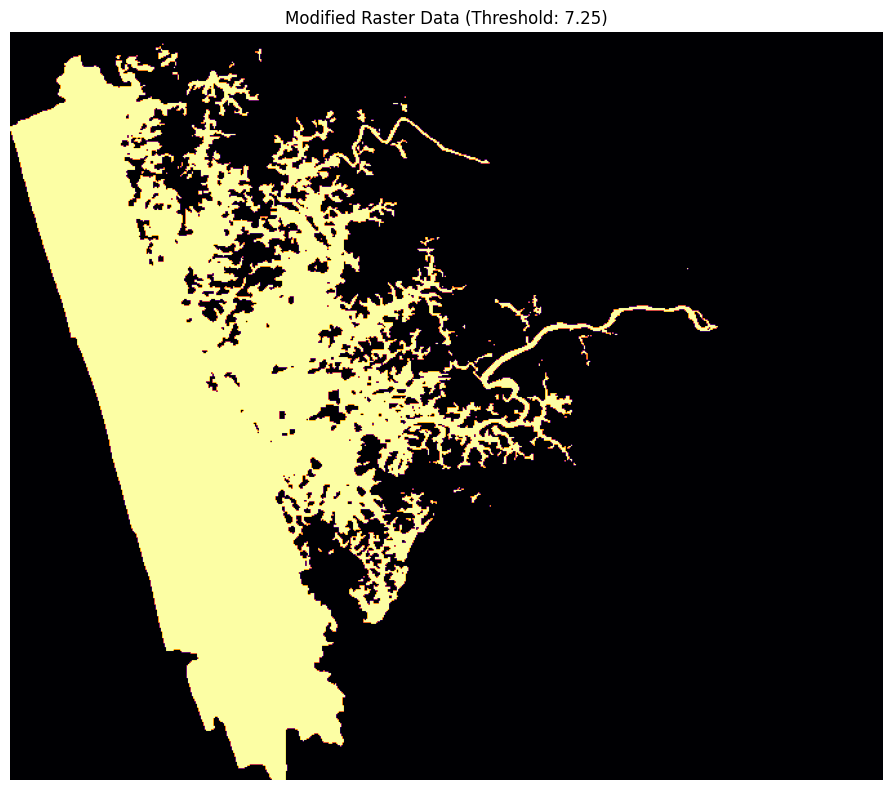

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.22148210691284	10.36552878	76.22231474641211	10.366361419499999
1	1	76.21731890941653	10.362198222	76.22064946741358	10.3646961405
2	1	76.21898418841506	10.356369745499999	76.22647794390842	10.363030861499999
3	1	76.20482931692761	10.3580350245	76.20566195642688	10.358867664
4	1	76.19150708493943	10.356369745499999	76.19483764293648	10.358867664
5	1	76.28143215085967	10.3547044665	76.28559534835598	10.363030861499999
6	1	76.22980850190547	10.352206548	76.23064114140472	10.3547044665
7	1	76.26644463987297	10.353871826999999	76.26727727937222	10.3547044665
8	1	76.22064946741358	10.3513739085	76.23147378090398	10.360532942999999
9	1	76.26477936087444	10.350541268999999	76.26810991887149	10.353871826999999
10	1	76.2289758624062	10.350541268999999	76.22980850190547	10.3513739085
11	1	76.19816820093352	10.3480433505	76.21648626991728	10.3580350245
12	1	76.22814322290694	10.346378071499998	76.23147378090

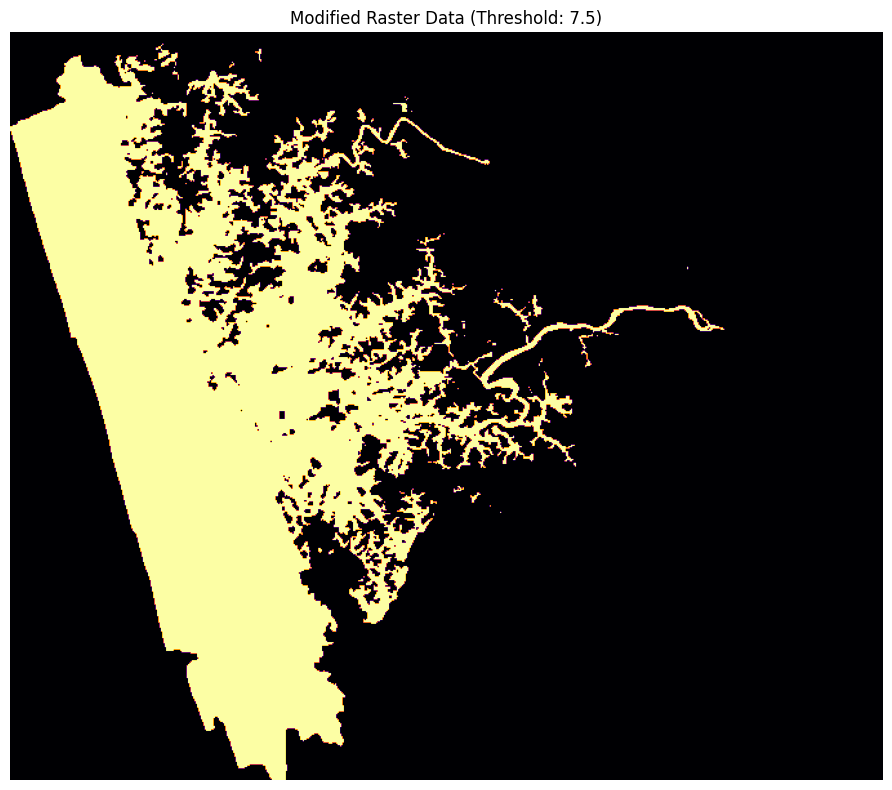

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.22148210691284	10.36552878	76.22231474641211	10.366361419499999
1	1	76.22064946741358	10.3646961405	76.22148210691284	10.36552878
2	1	76.21731890941653	10.362198222	76.22064946741358	10.3646961405
3	1	76.21898418841506	10.356369745499999	76.22647794390842	10.363030861499999
4	1	76.20482931692761	10.3580350245	76.20566195642688	10.358867664
5	1	76.28143215085967	10.3547044665	76.28559534835598	10.363030861499999
6	1	76.21648626991728	10.355537106	76.2181515489158	10.356369745499999
7	1	76.20982515392319	10.3547044665	76.21065779342244	10.355537106
8	1	76.22980850190547	10.352206548	76.23064114140472	10.3547044665
9	1	76.26644463987297	10.353871826999999	76.26727727937222	10.3547044665
10	1	76.22064946741358	10.3513739085	76.23147378090398	10.360532942999999
11	1	76.26477936087444	10.350541268999999	76.26810991887149	10.353871826999999
12	1	76.2289758624062	10.350541268999999	76.22980850190547	10.35

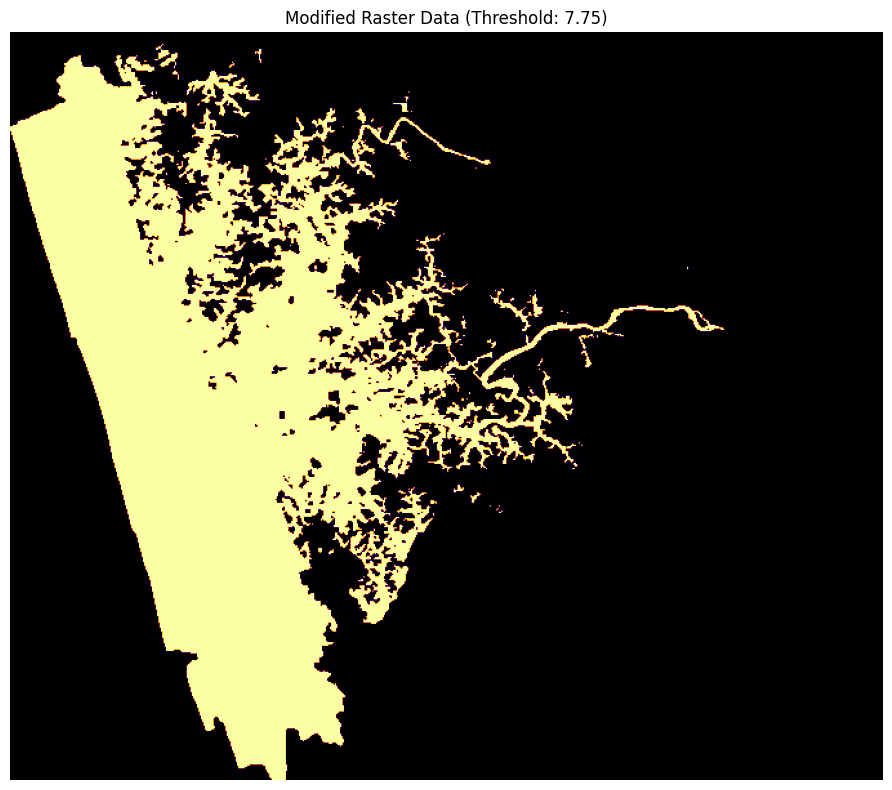

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.22148210691284	10.36552878	76.22231474641211	10.366361419499999
1	1	76.22064946741358	10.3646961405	76.22148210691284	10.36552878
2	1	76.21731890941653	10.362198222	76.22064946741358	10.3646961405
3	1	76.21898418841506	10.356369745499999	76.22647794390842	10.363030861499999
4	1	76.20482931692761	10.3580350245	76.20566195642688	10.358867664
5	1	76.28143215085967	10.353871826999999	76.28559534835598	10.363030861499999
6	1	76.21648626991728	10.355537106	76.21898418841506	10.356369745499999
7	1	76.20982515392319	10.3547044665	76.2114904329217	10.355537106
8	1	76.22980850190547	10.352206548	76.23064114140472	10.3547044665
9	1	76.26644463987297	10.353871826999999	76.26727727937222	10.3547044665
10	1	76.21981682791433	10.3513739085	76.23147378090398	10.360532942999999
11	1	76.2289758624062	10.350541268999999	76.22980850190547	10.352206548
12	1	76.26477936087444	10.350541268999999	76.26810991887149	10.353

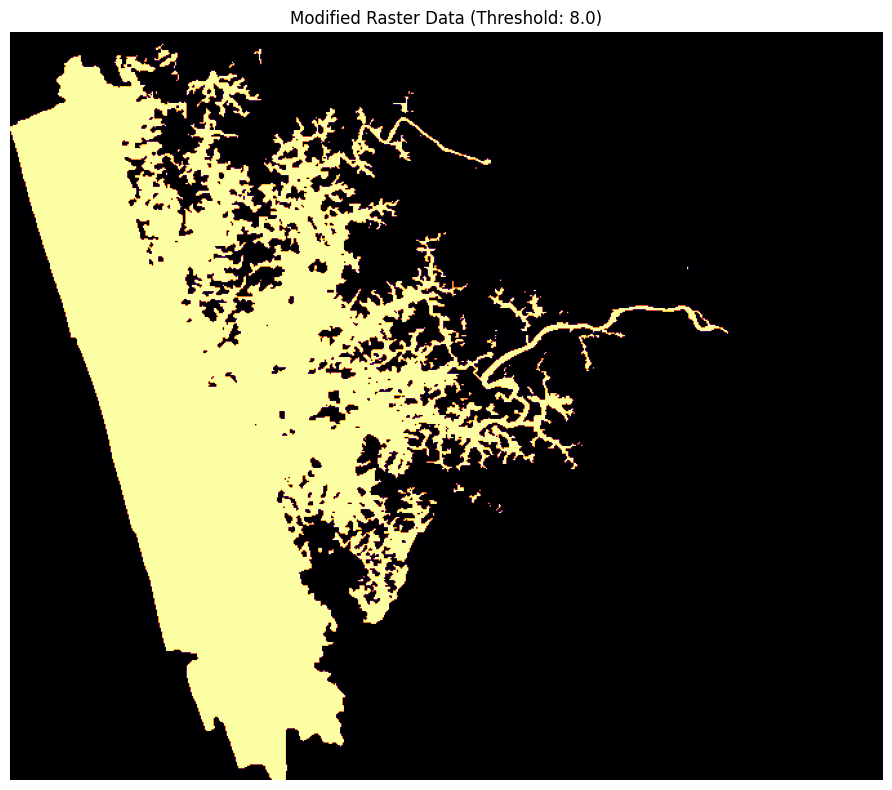

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.22148210691284	10.36552878	76.22231474641211	10.366361419499999
1	1	76.22064946741358	10.3646961405	76.22148210691284	10.36552878
2	1	76.21731890941653	10.362198222	76.22064946741358	10.3646961405
3	1	76.20482931692761	10.3580350245	76.20566195642688	10.358867664
4	1	76.2805995113604	10.353039187499999	76.28559534835598	10.363030861499999
5	1	76.21648626991728	10.355537106	76.22647794390842	10.363030861499999
6	1	76.20982515392319	10.3547044665	76.2114904329217	10.357202384999999
7	1	76.22980850190547	10.352206548	76.23064114140472	10.3547044665
8	1	76.26644463987297	10.353871826999999	76.26727727937222	10.3547044665
9	1	76.21981682791433	10.3513739085	76.23147378090398	10.360532942999999
10	1	76.2289758624062	10.350541268999999	76.22980850190547	10.352206548
11	1	76.26477936087444	10.350541268999999	76.26810991887149	10.353871826999999
12	1	76.22731058340767	10.346378071499998	76.23147378090398	1

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.22148210691284	10.36552878	76.22231474641211	10.366361419499999
1	1	76.22064946741358	10.3646961405	76.22148210691284	10.36552878
2	1	76.21731890941653	10.362198222	76.22064946741358	10.3646961405
3	1	76.20482931692761	10.3580350245	76.20566195642688	10.358867664
4	1	76.2805995113604	10.353039187499999	76.28559534835598	10.363030861499999
5	1	76.20982515392319	10.3547044665	76.2114904329217	10.357202384999999
6	1	76.21565363041802	10.355537106	76.22647794390842	10.363030861499999
7	1	76.26644463987297	10.353871826999999	76.26727727937222	10.3547044665
8	1	76.21981682791433	10.3513739085	76.23147378090398	10.360532942999999
9	1	76.2289758624062	10.350541268999999	76.22980850190547	10.352206548
10	1	76.26477936087444	10.350541268999999	76.26810991887149	10.353871826999999
11	1	76.22731058340767	10.346378071499998	76.23147378090398	10.34887599
12	1	76.23147378090398	10.3430475135	76.23230642040325	10

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.22064946741358	10.3646961405	76.22231474641211	10.366361419499999
1	1	76.2805995113604	10.353039187499999	76.28559534835598	10.363030861499999
2	1	76.21565363041802	10.355537106	76.22647794390842	10.3646961405
3	1	76.26644463987297	10.353871826999999	76.26727727937222	10.3547044665
4	1	76.21981682791433	10.3513739085	76.23147378090398	10.360532942999999
5	1	76.2289758624062	10.350541268999999	76.22980850190547	10.352206548
6	1	76.26477936087444	10.350541268999999	76.26810991887149	10.353871826999999
7	1	76.22731058340767	10.346378071499998	76.23147378090398	10.34887599
8	1	76.23147378090398	10.3430475135	76.23230642040325	10.346378071499998
9	1	76.23064114140472	10.342214874	76.23147378090398	10.3430475135
10	1	76.37968361177252	10.333888478999999	76.38384680926883	10.3363863975
11	1	76.36885929828212	10.3263947235	76.36969193778138	10.327227362999999
12	1	76.36802665878287	10.325562084	76.3688592

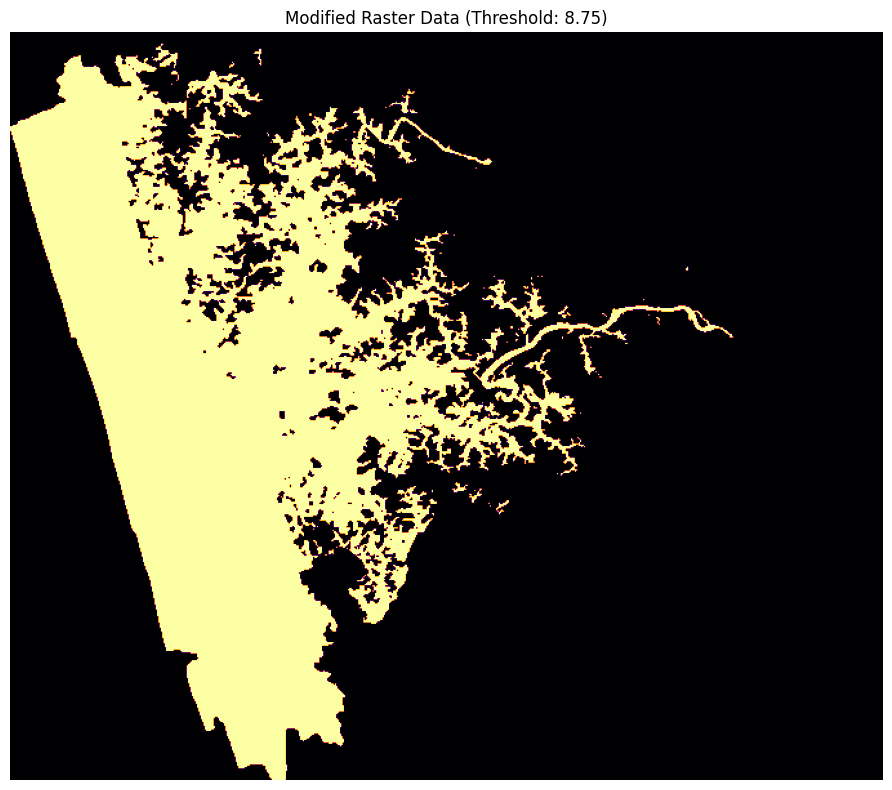

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.22064946741358	10.3646961405	76.22231474641211	10.366361419499999
1	1	76.21482099091875	10.357202384999999	76.21565363041802	10.3580350245
2	1	76.21565363041802	10.3547044665	76.22647794390842	10.3646961405
3	1	76.26644463987297	10.353871826999999	76.26727727937222	10.3547044665
4	1	76.2805995113604	10.352206548	76.28559534835598	10.363030861499999
5	1	76.21981682791433	10.350541268999999	76.23147378090398	10.360532942999999
6	1	76.26477936087444	10.350541268999999	76.26810991887149	10.353871826999999
7	1	76.22731058340767	10.346378071499998	76.23147378090398	10.34887599
8	1	76.23147378090398	10.3430475135	76.23230642040325	10.346378071499998
9	1	76.23064114140472	10.342214874	76.23147378090398	10.3430475135
10	1	76.22731058340767	10.3397169555	76.22814322290694	10.340549594999999
11	1	76.37968361177252	10.333888478999999	76.3846794487681	10.337219036999999
12	1	76.37635305377547	10.3322232	76.377

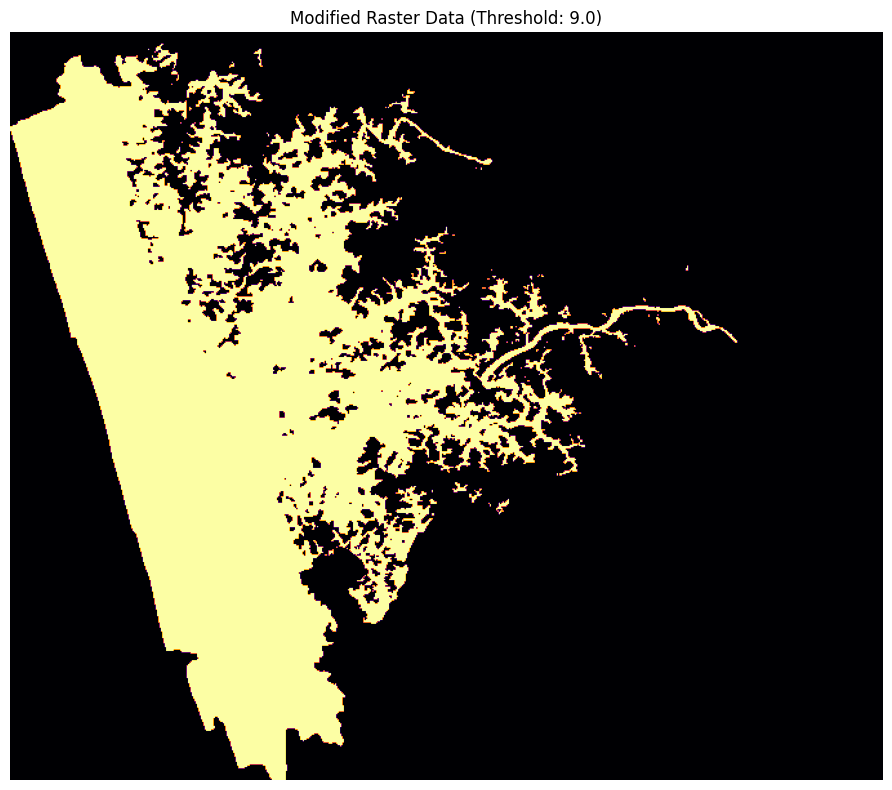

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.21232307242097	10.362198222	76.21315571192024	10.363030861499999
1	1	76.21648626991728	10.360532942999999	76.21731890941653	10.3613655825
2	1	76.21482099091875	10.357202384999999	76.21565363041802	10.358867664
3	1	76.26644463987297	10.353871826999999	76.26727727937222	10.3547044665
4	1	76.2805995113604	10.3513739085	76.28642798785523	10.363030861499999
5	1	76.21565363041802	10.350541268999999	76.23147378090398	10.366361419499999
6	1	76.26477936087444	10.350541268999999	76.26810991887149	10.353871826999999
7	1	76.22814322290694	10.349708629499998	76.2289758624062	10.350541268999999
8	1	76.22731058340767	10.346378071499998	76.23147378090398	10.34887599
9	1	76.23064114140472	10.342214874	76.23230642040325	10.346378071499998
10	1	76.22731058340767	10.3397169555	76.22814322290694	10.340549594999999
11	1	76.37968361177252	10.333888478999999	76.3846794487681	10.337219036999999
12	1	76.37635305377547	10.3

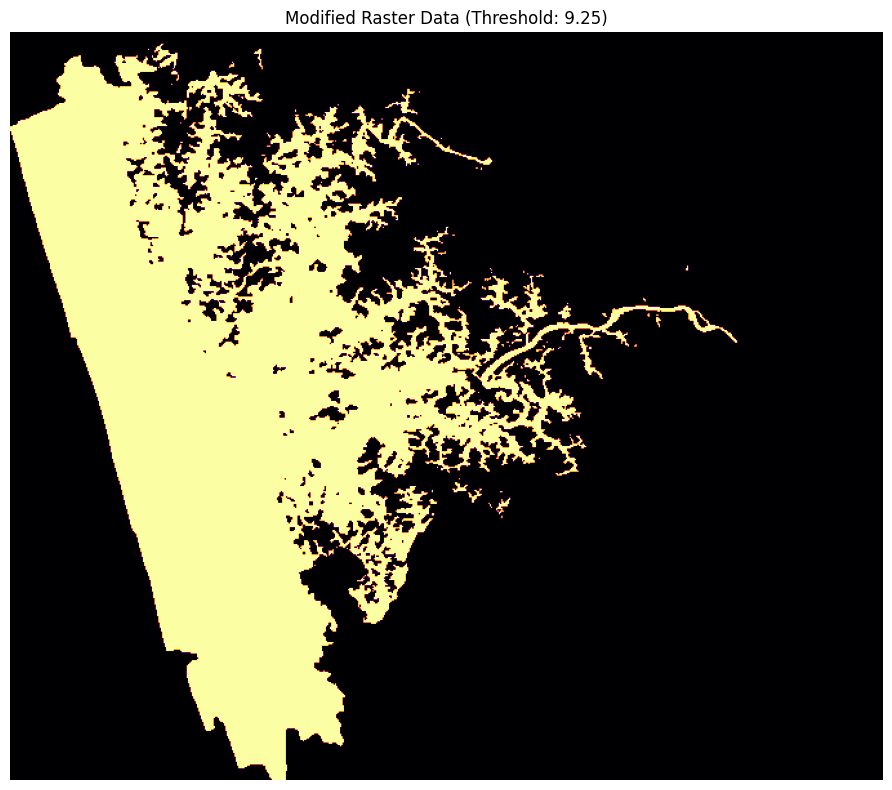

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.21232307242097	10.362198222	76.21315571192024	10.363030861499999
1	1	76.21482099091875	10.357202384999999	76.21565363041802	10.358867664
2	1	76.26644463987297	10.353871826999999	76.26727727937222	10.3547044665
3	1	76.21565363041802	10.350541268999999	76.23147378090398	10.366361419499999
4	1	76.2805995113604	10.349708629499998	76.28642798785523	10.363030861499999
5	1	76.26477936087444	10.350541268999999	76.26810991887149	10.353871826999999
6	1	76.21898418841506	10.350541268999999	76.21981682791433	10.3513739085
7	1	76.22814322290694	10.349708629499998	76.2289758624062	10.350541268999999
8	1	76.22731058340767	10.346378071499998	76.23147378090398	10.34887599
9	1	76.23064114140472	10.342214874	76.23230642040325	10.346378071499998
10	1	76.22731058340767	10.3397169555	76.22814322290694	10.340549594999999
11	1	76.38717736726588	10.3347211185	76.38801000676514	10.335553758
12	1	76.27060783736927	10.332223

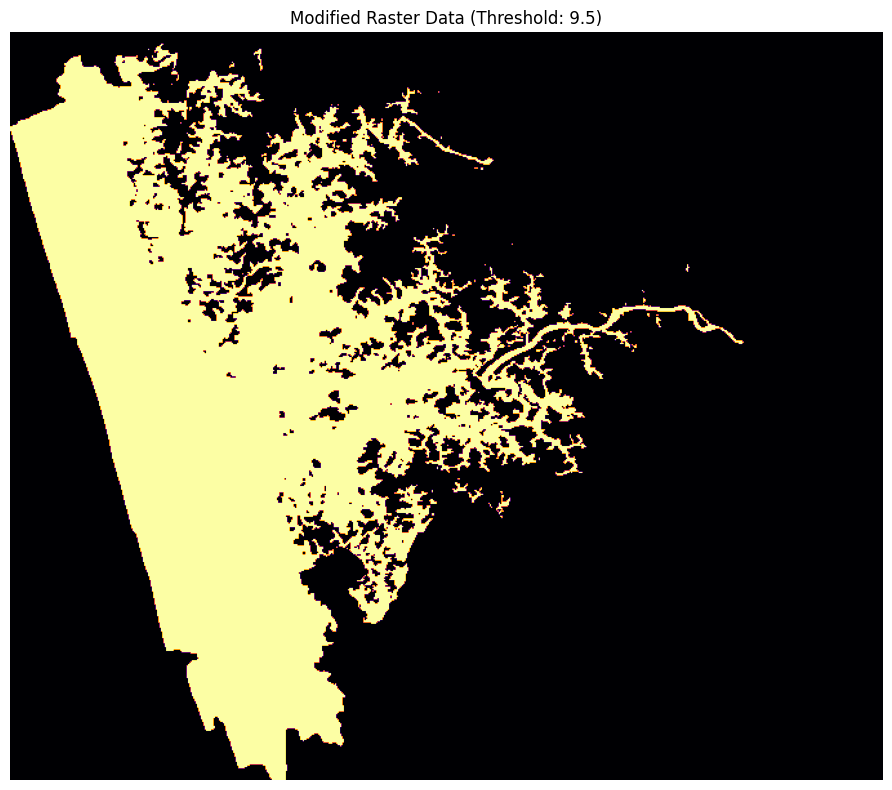

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.21232307242097	10.362198222	76.21315571192024	10.363030861499999
1	1	76.21482099091875	10.357202384999999	76.21565363041802	10.358867664
2	1	76.26644463987297	10.353871826999999	76.26727727937222	10.3547044665
3	1	76.26477936087444	10.350541268999999	76.26810991887149	10.353871826999999
4	1	76.22814322290694	10.349708629499998	76.2289758624062	10.350541268999999
5	1	76.2805995113604	10.34887599	76.28642798785523	10.363030861499999
6	1	76.22731058340767	10.346378071499998	76.23147378090398	10.34887599
7	1	76.23064114140472	10.342214874	76.23230642040325	10.346378071499998
8	1	76.21565363041802	10.3397169555	76.21648626991728	10.340549594999999
9	1	76.22731058340767	10.3397169555	76.22814322290694	10.340549594999999
10	1	76.38634472776661	10.3347211185	76.38801000676514	10.3363863975
11	1	76.3996669597548	10.3347211185	76.40049959925406	10.335553758
12	1	76.38801000676514	10.333888478999999	76.38884

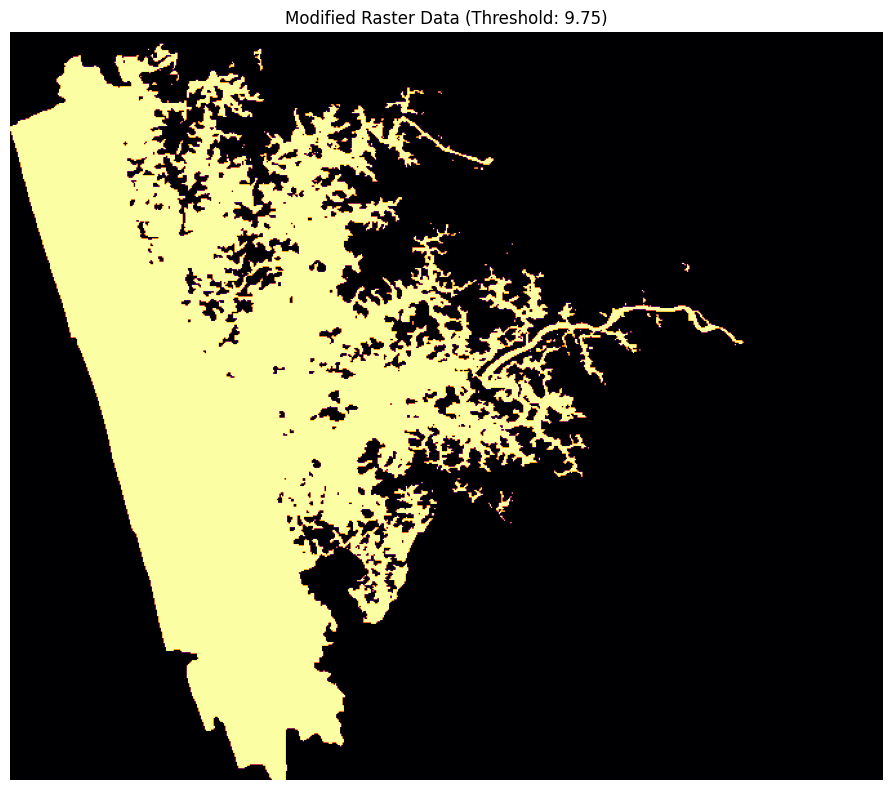

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.21232307242097	10.362198222	76.21315571192024	10.363030861499999
1	1	76.21398835141949	10.357202384999999	76.21565363041802	10.359700303499999
2	1	76.26644463987297	10.353871826999999	76.26727727937222	10.3547044665
3	1	76.26477936087444	10.350541268999999	76.26810991887149	10.353871826999999
4	1	76.22814322290694	10.349708629499998	76.2289758624062	10.350541268999999
5	1	76.2805995113604	10.34887599	76.28642798785523	10.363030861499999
6	1	76.21981682791433	10.34887599	76.22064946741358	10.349708629499998
7	1	76.22647794390842	10.346378071499998	76.23147378090398	10.34887599
8	1	76.2073272354254	10.3447127925	76.20815987492466	10.345545432
9	1	76.23064114140472	10.342214874	76.23230642040325	10.346378071499998
10	1	76.21482099091875	10.3397169555	76.2181515489158	10.3413822345
11	1	76.22731058340767	10.3397169555	76.22814322290694	10.340549594999999
12	1	76.3996669597548	10.3347211185	76.40133223

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.21232307242097	10.362198222	76.21315571192024	10.363030861499999
1	1	76.26644463987297	10.353871826999999	76.26727727937222	10.3547044665
2	1	76.26477936087444	10.350541268999999	76.26810991887149	10.353871826999999
3	1	76.22814322290694	10.349708629499998	76.2289758624062	10.350541268999999
4	1	76.2805995113604	10.34887599	76.2872606273545	10.363030861499999
5	1	76.22647794390842	10.345545432	76.23147378090398	10.34887599
6	1	76.2114904329217	10.3447127925	76.21232307242097	10.345545432
7	1	76.23064114140472	10.342214874	76.23230642040325	10.346378071499998
8	1	76.21482099091875	10.338884316	76.2181515489158	10.3413822345
9	1	76.22731058340767	10.3397169555	76.22814322290694	10.340549594999999
10	1	76.22481266490989	10.3363863975	76.22564530440916	10.337219036999999
11	1	76.3996669597548	10.333888478999999	76.40216487825258	10.335553758
12	1	76.39134056476219	10.3322232	76.39217320426144	10.33305

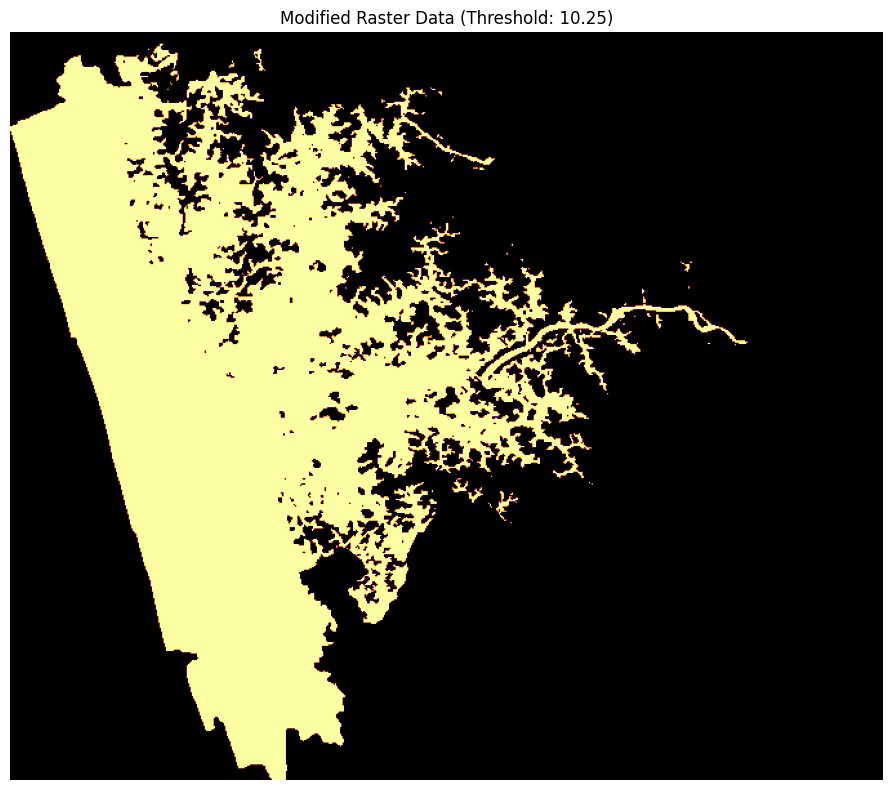

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.21232307242097	10.362198222	76.21315571192024	10.363030861499999
1	1	76.26644463987297	10.353871826999999	76.26727727937222	10.355537106
2	1	76.26477936087444	10.350541268999999	76.26810991887149	10.353871826999999
3	1	76.22814322290694	10.349708629499998	76.2289758624062	10.350541268999999
4	1	76.2805995113604	10.34887599	76.2872606273545	10.363030861499999
5	1	76.2872606273545	10.34887599	76.28809326685376	10.349708629499998
6	1	76.22647794390842	10.345545432	76.23147378090398	10.34887599
7	1	76.23064114140472	10.342214874	76.23230642040325	10.346378071499998
8	1	76.21398835141949	10.3380516765	76.21898418841506	10.3413822345
9	1	76.22647794390842	10.340549594999999	76.22731058340767	10.3413822345
10	1	76.22731058340767	10.3397169555	76.22814322290694	10.340549594999999
11	1	76.39467112275923	10.337219036999999	76.39550376225849	10.3380516765
12	1	76.22481266490989	10.3363863975	76.2256453044091

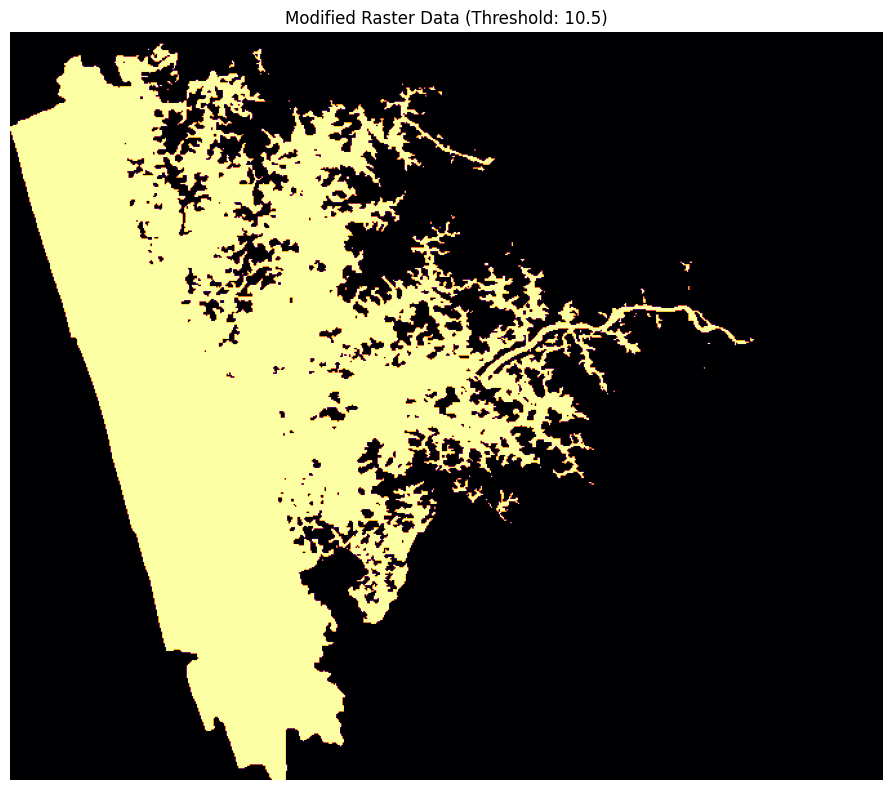

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.21232307242097	10.362198222	76.21315571192024	10.363030861499999
1	1	76.26477936087444	10.350541268999999	76.26810991887149	10.355537106
2	1	76.22814322290694	10.349708629499998	76.2289758624062	10.350541268999999
3	1	76.27976687186116	10.3480433505	76.28809326685376	10.363030861499999
4	1	76.22647794390842	10.345545432	76.23147378090398	10.34887599
5	1	76.28476270885672	10.346378071499998	76.28559534835598	10.347210710999999
6	1	76.28975854585228	10.346378071499998	76.29059118535154	10.347210710999999
7	1	76.23064114140472	10.342214874	76.23230642040325	10.346378071499998
8	1	76.22481266490989	10.340549594999999	76.22731058340767	10.342214874
9	1	76.22980850190547	10.3413822345	76.23064114140472	10.342214874
10	1	76.22731058340767	10.3397169555	76.22814322290694	10.340549594999999
11	1	76.37635305377547	10.3397169555	76.37718569327474	10.340549594999999
12	1	76.21981682791433	10.338884316	76.2214

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.21232307242097	10.362198222	76.21315571192024	10.363030861499999
1	1	76.26477936087444	10.350541268999999	76.26810991887149	10.355537106
2	1	76.22814322290694	10.349708629499998	76.2289758624062	10.350541268999999
3	1	76.27976687186116	10.3480433505	76.28809326685376	10.363030861499999
4	1	76.22647794390842	10.345545432	76.23147378090398	10.34887599
5	1	76.28393006935745	10.346378071499998	76.28559534835598	10.347210710999999
6	1	76.28975854585228	10.346378071499998	76.29059118535154	10.347210710999999
7	1	76.23064114140472	10.342214874	76.23230642040325	10.346378071499998
8	1	76.22481266490989	10.3397169555	76.22814322290694	10.342214874
9	1	76.22980850190547	10.3413822345	76.23064114140472	10.342214874
10	1	76.37552041427621	10.3413822345	76.37635305377547	10.342214874
11	1	76.37635305377547	10.3397169555	76.37718569327474	10.3413822345
12	1	76.21981682791433	10.338884316	76.22148210691284	10.33

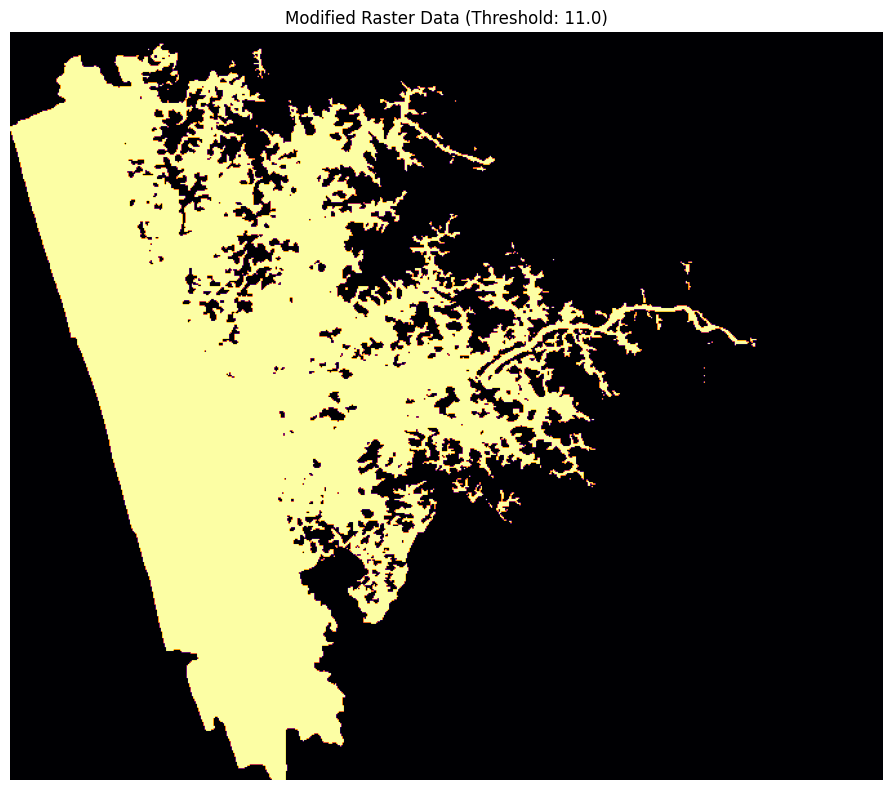

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.21232307242097	10.362198222	76.21315571192024	10.363030861499999
1	1	76.26477936087444	10.350541268999999	76.26894255837075	10.355537106
2	1	76.28143215085967	10.34887599	76.28226479035894	10.349708629499998
3	1	76.22647794390842	10.345545432	76.23147378090398	10.34887599
4	1	76.27976687186116	10.345545432	76.28809326685376	10.363030861499999
5	1	76.28975854585228	10.346378071499998	76.29059118535154	10.347210710999999
6	1	76.2830974298582	10.3447127925	76.28393006935745	10.345545432
7	1	76.28559534835598	10.343880152999999	76.28642798785523	10.345545432
8	1	76.23064114140472	10.342214874	76.23230642040325	10.346378071499998
9	1	76.22980850190547	10.3413822345	76.23064114140472	10.342214874
10	1	76.37552041427621	10.3413822345	76.37635305377547	10.342214874
11	1	76.22398002541063	10.3397169555	76.22814322290694	10.342214874
12	1	76.22148210691284	10.3397169555	76.22231474641211	10.340549594999999


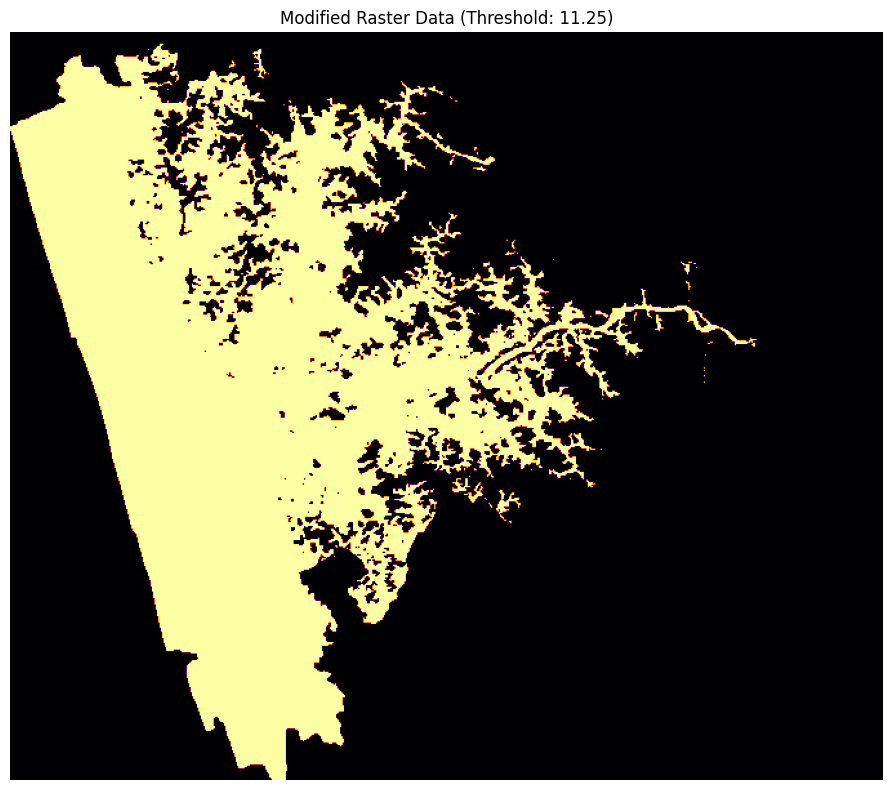

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.21232307242097	10.362198222	76.21315571192024	10.363030861499999
1	1	76.26477936087444	10.350541268999999	76.26894255837075	10.355537106
2	1	76.2805995113604	10.34887599	76.28226479035894	10.349708629499998
3	1	76.28975854585228	10.346378071499998	76.29059118535154	10.347210710999999
4	1	76.27976687186116	10.343880152999999	76.28892590635303	10.363030861499999
5	1	76.22647794390842	10.342214874	76.23230642040325	10.34887599
6	1	76.22980850190547	10.3413822345	76.23064114140472	10.342214874
7	1	76.37552041427621	10.3413822345	76.37635305377547	10.342214874
8	1	76.22231474641211	10.3397169555	76.22814322290694	10.342214874
9	1	76.22148210691284	10.3397169555	76.22231474641211	10.340549594999999
10	1	76.22481266490989	10.3363863975	76.22564530440916	10.337219036999999
11	1	76.3930058437607	10.3330558395	76.40299751775184	10.338884316
12	1	76.40716071524815	10.3313905605	76.40799335474742	10.3322232
1

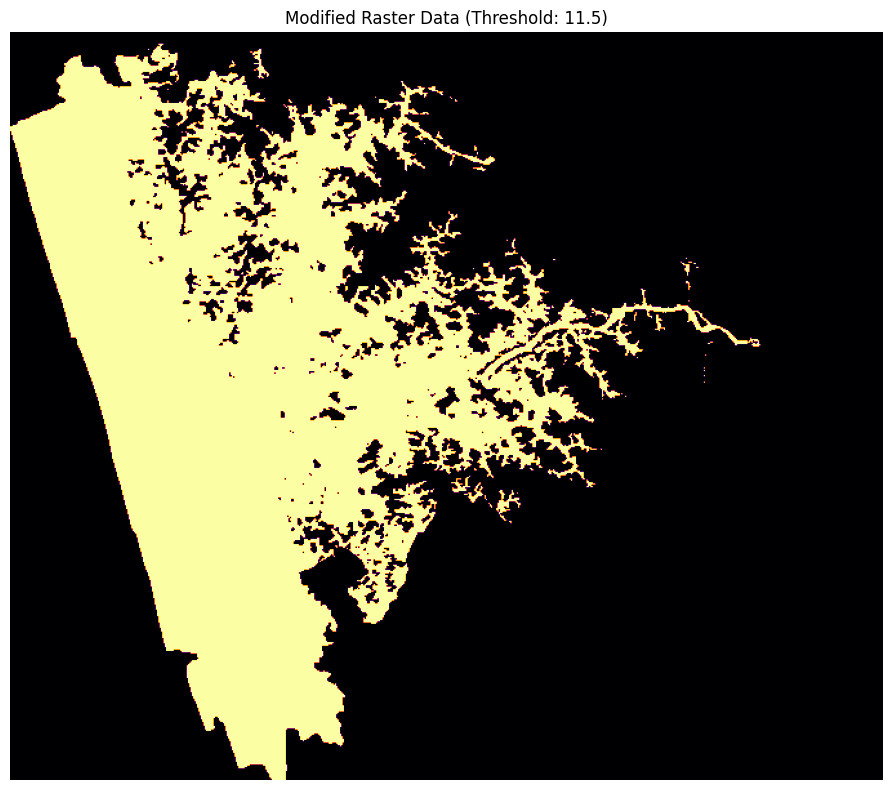

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.21232307242097	10.362198222	76.21315571192024	10.363030861499999
1	1	76.27810159286263	10.360532942999999	76.27976687186116	10.3613655825
2	1	76.26477936087444	10.350541268999999	76.26894255837075	10.355537106
3	1	76.2805995113604	10.34887599	76.28226479035894	10.349708629499998
4	1	76.27976687186116	10.343880152999999	76.29059118535154	10.363030861499999
5	1	76.22647794390842	10.342214874	76.23230642040325	10.34887599
6	1	76.22980850190547	10.3413822345	76.23064114140472	10.342214874
7	1	76.22481266490989	10.3363863975	76.22564530440916	10.337219036999999
8	1	76.3930058437607	10.3330558395	76.40299751775184	10.338884316
9	1	76.358867624291	10.3313905605	76.35970026379024	10.3322232
10	1	76.40716071524815	10.3313905605	76.40799335474742	10.3322232
11	1	76.2872606273545	10.330557920999999	76.28809326685376	10.3313905605
12	1	76.40799335474742	10.330557920999999	76.40882599424667	10.3313905605
13	1	

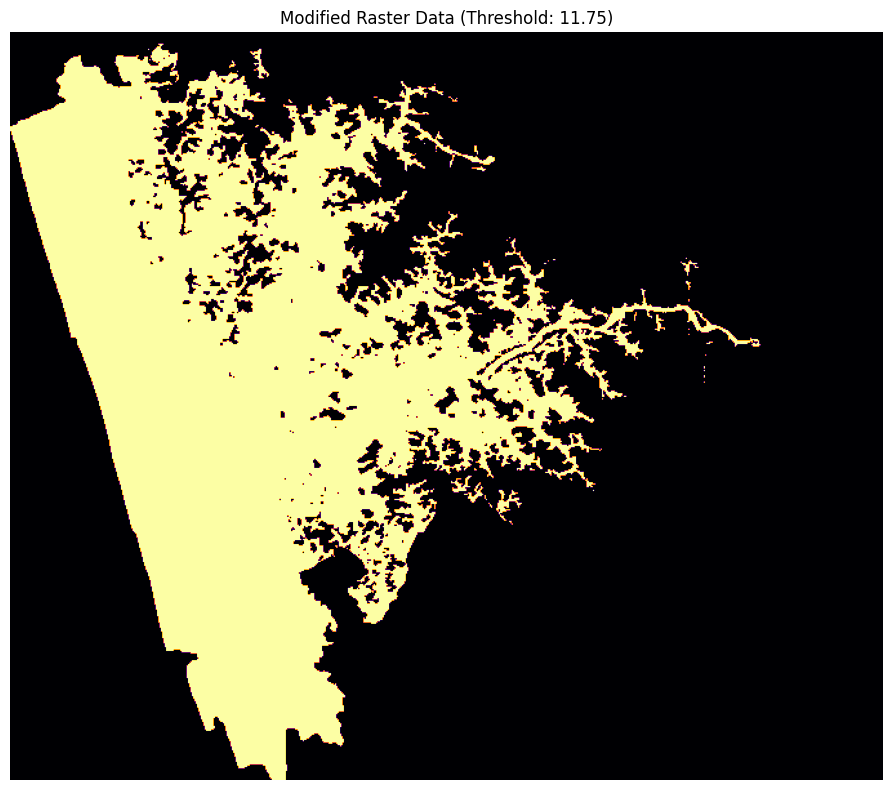

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.21232307242097	10.362198222	76.21315571192024	10.363030861499999
1	1	76.21315571192024	10.355537106	76.21398835141949	10.356369745499999
2	1	76.26477936087444	10.350541268999999	76.26894255837075	10.355537106
3	1	76.2805995113604	10.34887599	76.28226479035894	10.349708629499998
4	1	76.26977519787002	10.3480433505	76.27060783736927	10.34887599
5	1	76.27810159286263	10.343880152999999	76.29059118535154	10.363030861499999
6	1	76.22647794390842	10.342214874	76.23230642040325	10.34887599
7	1	76.22980850190547	10.3413822345	76.23064114140472	10.342214874
8	1	76.39716904125702	10.3397169555	76.39800168075628	10.340549594999999
9	1	76.22481266490989	10.3363863975	76.22564530440916	10.337219036999999
10	1	76.3930058437607	10.3330558395	76.40299751775184	10.338884316
11	1	76.35803498479173	10.3313905605	76.36053290328951	10.3322232
12	1	76.40632807574889	10.3313905605	76.40799335474742	10.3322232
13	1	76.40

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.21232307242097	10.362198222	76.21398835141949	10.363030861499999
1	1	76.26477936087444	10.350541268999999	76.26894255837075	10.355537106
2	1	76.26977519787002	10.3480433505	76.27060783736927	10.34887599
3	1	76.27726895336336	10.343880152999999	76.29059118535154	10.363030861499999
4	1	76.22564530440916	10.342214874	76.23230642040325	10.34887599
5	1	76.22980850190547	10.3413822345	76.23064114140472	10.342214874
6	1	76.22398002541063	10.3363863975	76.22564530440916	10.337219036999999
7	1	76.3930058437607	10.3330558395	76.40383015725111	10.340549594999999
8	1	76.39467112275923	10.333888478999999	76.39550376225849	10.3347211185
9	1	76.21981682791433	10.3322232	76.22148210691284	10.3330558395
10	1	76.28809326685376	10.3313905605	76.28892590635303	10.3322232
11	1	76.35803498479173	10.330557920999999	76.36136554278877	10.3330558395
12	1	76.30224813834121	10.330557920999999	76.30308077784046	10.3313905605


Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.21232307242097	10.362198222	76.21398835141949	10.363030861499999
1	1	76.26477936087444	10.350541268999999	76.26894255837075	10.355537106
2	1	76.26977519787002	10.3480433505	76.27060783736927	10.34887599
3	1	76.30641133583751	10.3480433505	76.30724397533677	10.34887599
4	1	76.27643631386411	10.343880152999999	76.29059118535154	10.363030861499999
5	1	76.22564530440916	10.342214874	76.23230642040325	10.34887599
6	1	76.22980850190547	10.3413822345	76.23064114140472	10.342214874
7	1	76.22398002541063	10.3363863975	76.22564530440916	10.337219036999999
8	1	76.39467112275923	10.333888478999999	76.39550376225849	10.3347211185
9	1	76.28809326685376	10.3313905605	76.28892590635303	10.3322232
10	1	76.35803498479173	10.330557920999999	76.36136554278877	10.3330558395
11	1	76.41132391274446	10.330557920999999	76.41215655224372	10.3313905605
12	1	76.40632807574889	10.328892642	76.41215655224372	10.3322232
13	1	76

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.21232307242097	10.362198222	76.21398835141949	10.363030861499999
1	1	76.26477936087444	10.350541268999999	76.26894255837075	10.355537106
2	1	76.26561200037371	10.349708629499998	76.26727727937222	10.350541268999999
3	1	76.26977519787002	10.3480433505	76.27144047686853	10.34887599
4	1	76.30641133583751	10.3480433505	76.30724397533677	10.34887599
5	1	76.27643631386411	10.343880152999999	76.29059118535154	10.363030861499999
6	1	76.22980850190547	10.3413822345	76.23064114140472	10.342214874
7	1	76.22398002541063	10.3363863975	76.22564530440916	10.337219036999999
8	1	76.39383848325997	10.3330558395	76.39550376225849	10.3347211185
9	1	76.22398002541063	10.3313905605	76.22481266490989	10.3322232
10	1	76.28809326685376	10.3313905605	76.28892590635303	10.3322232
11	1	76.35553706629395	10.3313905605	76.3563697057932	10.3322232
12	1	76.35803498479173	10.330557920999999	76.36219818228804	10.3330558395
13	1	76

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.21232307242097	10.362198222	76.21398835141949	10.363030861499999
1	1	76.26477936087444	10.34887599	76.26894255837075	10.355537106
2	1	76.27310575586706	10.34887599	76.27393839536632	10.349708629499998
3	1	76.26977519787002	10.3480433505	76.27144047686853	10.34887599
4	1	76.30641133583751	10.3480433505	76.30807661483604	10.34887599
5	1	76.27643631386411	10.343880152999999	76.29059118535154	10.363030861499999
6	1	76.33139052081536	10.343880152999999	76.33222316031463	10.3447127925
7	1	76.22398002541063	10.3363863975	76.22564530440916	10.337219036999999
8	1	76.39383848325997	10.3330558395	76.39633640175775	10.3347211185
9	1	76.22398002541063	10.3313905605	76.22481266490989	10.3322232
10	1	76.2439633733929	10.3313905605	76.24479601289217	10.3322232
11	1	76.28809326685376	10.3313905605	76.28892590635303	10.3322232
12	1	76.35553706629395	10.3313905605	76.3563697057932	10.3322232
13	1	76.40632807574889	1

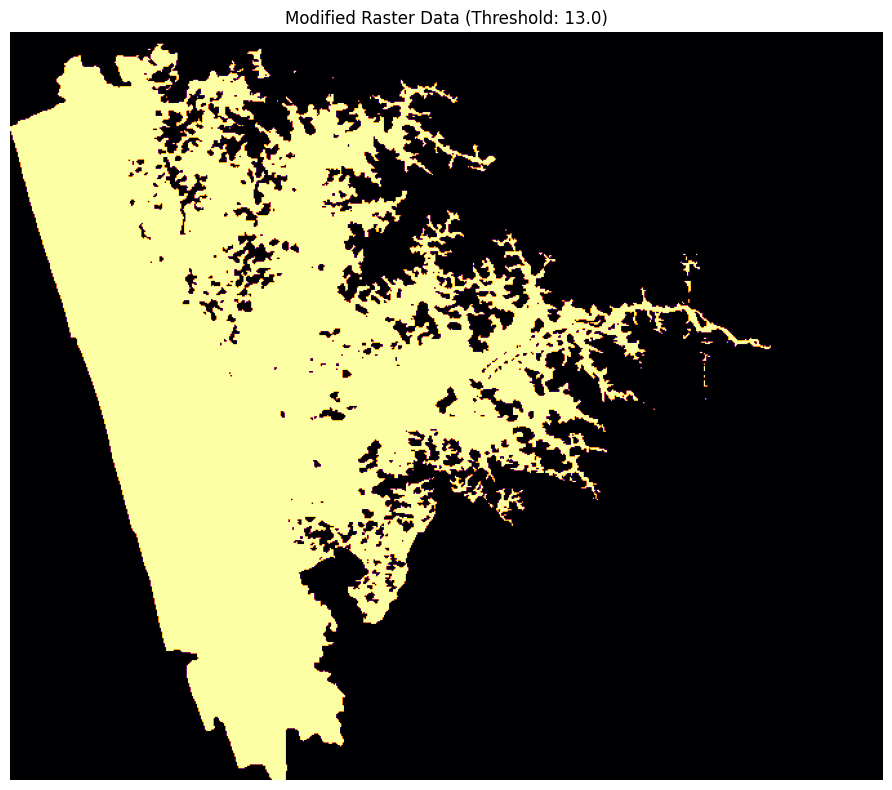

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.21232307242097	10.362198222	76.21398835141949	10.363030861499999
1	1	76.26477936087444	10.34887599	76.26894255837075	10.355537106
2	1	76.26977519787002	10.3480433505	76.27393839536632	10.350541268999999
3	1	76.30641133583751	10.347210710999999	76.30807661483604	10.34887599
4	1	76.27643631386411	10.343880152999999	76.29142382485081	10.363030861499999
5	1	76.33139052081536	10.343880152999999	76.33222316031463	10.3447127925
6	1	76.22647794390842	10.3380516765	76.22731058340767	10.338884316
7	1	76.22564530440916	10.337219036999999	76.22647794390842	10.3380516765
8	1	76.22398002541063	10.3363863975	76.22564530440916	10.337219036999999
9	1	76.39383848325997	10.3330558395	76.39633640175775	10.3347211185
10	1	76.35720234529246	10.3322232	76.35803498479173	10.3330558395
11	1	76.22398002541063	10.3313905605	76.22481266490989	10.3322232
12	1	76.2439633733929	10.3313905605	76.24479601289217	10.3322232
13	1	76

In [ ]:
# Example usage:
input_tiff = "/content/drive/MyDrive/Lowerbasin/lowerbasin_dem.tif"
# thresholds = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
# thresholds = np.arange(0.0, 13.0, 0.25).round(2).tolist()
thresholds = [0.0,1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75,
4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.0, 7.25,
7.5, 7.75, 8.0, 8.25, 8.5, 8.75, 9.0, 9.25, 9.5, 9.75, 10.0, 10.25, 10.5, 10.75, 11.0, 11.25, 11.5, 11.75, 12.0, 12.25, 12.5, 12.75, 13.0]

# thresholds = [12.48]
for threshold in thresholds:
    output_tiff = f"/content/drive/MyDrive/Lowerbasin/EXTRACTED_FILES/{threshold}LOWER.tif"
    output_shp = f"/content/drive/MyDrive/Lowerbasin/EXTRACTED_FILES/{threshold}poly_lower.shp"

    process_raster_data(input_tiff, output_tiff, output_shp, threshold) # changed 'thresholds' to 'threshold'

In [ ]:
!pip install gdal
!apt install gdal-bin python-gdal python3-gdal

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package python-gdal is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source
However the following packages replace it:
  gdal-bin

E: Package 'python-gdal' has no installation candidate


In [15]:
import geopandas as gpd

# Define the output shapefile path for shp1

for threshold in thresholds:
    thresholds = [7.0]
    output_shp = f"/content/drive/MyDrive/Lowerbasin/EXTRACTED_FILES/{threshold}poly_lower.shp"

    # Load the shapefile (shp1)
    shp1_gdf = gpd.read_file(output_shp)

    # Load the boundary shapefile (shp2)
    boundary_gdf = gpd.read_file('/content/drive/MyDrive/Lowerbasin/lower_basin_lsg_panchayat.shp')

    # Reproject both GeoDataFrames to EPSG:32643
    projected_crs = 'EPSG:32643'
    shp1_projected = shp1_gdf.to_crs(projected_crs)
    boundary_projected = boundary_gdf.to_crs(projected_crs)

    # Create a table to store the results
    results = []

    # Loop through each polygon in the boundary shapefile
    for i, polygon in boundary_projected.iterrows():
        # Clip the shp1 within the current polygon
        clipped_features = gpd.clip(shp1_projected, polygon.geometry)

        # Calculate the area of the clipped features in square kilometers
        clipped_area = clipped_features.area.sum() / 10**6  # Convert from m² to km²

        # Append the results to the table
        results.append({
            'Polygon Name': polygon['name'],  # Assuming 'name' is the field for polygon names
            'Clipped Area (km²)': clipped_area
        })

    # Create a DataFrame from the results
    results_df = gpd.GeoDataFrame(results)

    # # Calculate the total area of all clipped features
    # total_clipped_area = results_df['Clipped Area (km²)'].sum()

    # # Append a row for the total clipped area
    # total_row = {'Polygon Name': 'Total Clipped', 'Clipped Area (km²)': total_clipped_area}
    # results_df = results_df.append(total_row, ignore_index=True)

    # Print the results
    print(results_df[['Polygon Name', 'Clipped Area (km²)']])

                    Polygon Name  Clipped Area (km²)
0                          Kochi           40.880779
1                      Kodassery            0.000000
2                      Pariyaram            0.000000
3                         Meloor            0.106844
4                        Koratty            0.000000
..                           ...                 ...
67                         Eloor            2.735489
68  Choornikkara Gramapanchayath            2.006337
69                   Kalamassery            5.924466
70      Edathala Gramapanchayath            0.931037
71                        Maradu            6.796854

[72 rows x 2 columns]


In [11]:
import geopandas as gpd
import pandas as pd # Import the pandas library with the alias 'pd'
from tabulate import tabulate
# Define the output shapefile path for shp1
thresholds = [12.48]
for threshold in thresholds:
    output_shp = f"/content/drive/MyDrive/Lowerbasin/EXTRACTED_FILES/{threshold}poly_lower.shp"

    # Load the shapefile (shp1)
    shp1_gdf = gpd.read_file(output_shp)

    # Load the boundary shapefile (shp2)
    boundary_gdf = gpd.read_file('/content/drive/MyDrive/Lowerbasin/lower_basin_lsg_panchayat.shp')

    # Reproject both GeoDataFrames to EPSG:32643
    projected_crs = 'EPSG:32643'
    shp1_projected = shp1_gdf.to_crs(projected_crs)
    boundary_projected = boundary_gdf.to_crs(projected_crs)

    # Create a table to store the results
    results = []

    # Loop through each polygon in the boundary shapefile
    for i, polygon in boundary_projected.iterrows():
        # Clip the shp1 within the current polygon
        clipped_features = gpd.clip(shp1_projected, polygon.geometry)

        # Calculate the area of the clipped features in square kilometers
        clipped_area = clipped_features.area.sum() / 10**6  # Convert from m² to km²

        # Append the results to the table
        results.append({
            'Polygon Name': polygon['name'],  # Assuming 'name' is the field for polygon names
            'Clipped Area (km²)': clipped_area
        })

    # Create a DataFrame from the results
    results_df = gpd.GeoDataFrame(results)

    # Calculate the total area of all clipped features
    total_clipped_area = results_df['Clipped Area (km²)'].sum()

    # Append a row for the total clipped area using pandas.concat
    total_row = gpd.GeoDataFrame([{'Polygon Name': 'Total Clipped', 'Clipped Area (km²)': total_clipped_area}])
    results_df = pd.concat([results_df, total_row], ignore_index=True) # Use pd.concat since pandas is imported as pd

    # Print the results
    print(tabulate(results_df[['Polygon Name', 'Clipped Area (km²)']]))

--  ---------------------------------------  ---------
 0  Kochi                                     99.6824
 1  Kodassery                                  1.58805
 2  Pariyaram                                  5.27205
 3  Meloor                                    10.0727
 4  Koratty                                    5.98515
 5  Aloor                                     12.7476
 6  Chalakudy                                 15.7612
 7  Kadukutty                                 15.2725
 8  Annamanada                                21.994
 9  Kuzhur                                    17.5966
10  Mala                                      19.8968
11  Poyya                                     16.6183
12  Kodungallur                               28.9476
13  Eriyad                                    16.4736
14  Edavilangu                                 7.6344
15  Sree Narayanapuram                        18.8479
16  Mathilakam                                12.8358
17  Perinjanam           